In [16]:
%load_ext autoreload
%autoreload 2
from importlib import reload

from collections import defaultdict

import numpy

import random
from matplotlib import pyplot as plt
from random import shuffle, choice, randint

import math
import keras
import tensorflow

from NN_utils import BigTable, WeightClip

import pickle
import zlib

def logistic(x, b,off):
    z = b*(x-off)
    return numpy.exp(z)/(1+numpy.exp(z))

def pr_to_spread(p, comps=1, as_A_and_D=True):
    per_comp_p = p**(1/(comps))
#     print("p         ", p)
#     print("per comp p", per_comp_p)
#     spread = -numpy.log((1.0/per_comp_p)-1.0)
    inv_sigmoid = lambda pr : ( -numpy.log((1/pr) -1) )
    spread = inv_sigmoid(per_comp_p)
#     print("spread    ", spread)
    if as_A_and_D:
        a = spread/2.0
        d = -spread/2.0
        return a,d
    else:
        return spread

print("started")


from sklearn.svm import SVR


def calc_probs_from_embs(students,questions):
    students2 = numpy.repeat(students, len(questions), axis=0)
    questions2 = numpy.tile(questions, (len(students),1))
    zmask = numpy.isclose(questions2,-10).astype(int)
    diffs = students2-questions2
    prs = 1.0/(1.0+ numpy.exp(-diffs))
    prs = numpy.maximum(zmask,prs)
    probs2 = numpy.prod(prs, axis=1).reshape(len(students), len(questions))
    return probs2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
started


In [17]:
def calc_arr_arr_err(split, real_wgts, pred_wgts, max_iter=10):
    from scipy.spatial.distance import cosine
# pred_wgts = numpy.round(pred_wgts,1)

    print(split, real_wgts.shape, pred_wgts.shape, max_iter)

    out_cols = [None] * len(real_wgts.T)
    curr_sel = None
    curr_ix = None
    n_iters = 10
    chosen = None
    curr_real_ix = None
    
    indices = range(len(real_wgts.T))

    min_total_err = math.inf
    best_dis = math.inf
    for i in range(max_iter): #len(indices)**2):
        real_used = set()
        pred_used = set()
        while len(pred_used) < len(indices):
            curr_err = math.inf
            curr_cos = math.inf
            for rix in numpy.random.permutation(indices):
                if rix in real_used:
                    continue
                real_col = real_wgts.T[rix]
                for cix in numpy.random.permutation(indices):
                    if cix in pred_used:
                        continue
                    pred_col = pred_wgts.T[cix]
                    pred_col = pred_col #* pred_q_col
                    err = numpy.mean(numpy.abs( pred_col - real_col))
                    
                    if err < curr_err:
                        curr_sel = pred_col
                        curr_err = err
                        curr_cos = 0#cosine(pred_col, real_col)
                        curr_ix = cix
                        curr_real_ix = rix
            real_used.add(curr_real_ix)
            pred_used.add(curr_ix)
            out_cols[curr_real_ix] = curr_sel
        out_col_arr = numpy.array(out_cols).T
        total_err = numpy.mean(numpy.abs( out_col_arr - real_wgts ))
        
        dis = 0
        mean_ll = numpy.mean( out_col_arr - real_wgts )
        if total_err < min_total_err:
            min_total_err = total_err
            total_q_err = numpy.mean(numpy.abs( out_col_arr[0:split] - real_wgts[0:split] ))
            total_s_err = numpy.mean(numpy.abs( out_col_arr[split:] - real_wgts[split:] ))
            best_ll = mean_ll
            chosen = out_col_arr
            best_dis = dis
    return chosen, min_total_err, total_q_err, total_s_err, mean_ll, best_dis


In [18]:
import copy
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
def plot_items(pred_list, real_items, s_offset):
    if real_items.shape[1]<2:
        print("real_items is only 1 component wide .. needs to be >1 to plot on a PCA graph")
        return None
    elif real_items.shape[1]==2:
        print("2 comps, so no dim reduc")
        tx=None
    else:
        tx = PCA(n_components=2)
#         tx = TSNE(n_components=2)
    fyrst = True
    Cs = []
    C_labs = []
    pred_list = numpy.array(pred_list)
    print("pred list shape", pred_list.shape)
    print("real items shape", real_items.shape)


    fitted_pred_list = []
#     offset = numpy.median(pred_list[(pred_list>0.1)], axis=0) - numpy.median(real_items[(real_items>0.1)], axis=0)
#     real_mean = numpy.min(real_items[real_items > 0.1])
#     offset = numpy.min(pred_list[pred_list > 0.1]) - real_mean
#     print("real mean", real_mean)
#     print("offset", offset)
    
    m = len(real_items)
    cols = list(range(m))
    shuffle(cols)
    
    xmeans = numpy.zeros(m)
    ymeans = numpy.zeros(m)
    pairs = defaultdict(list)
    iter = 0
    
    cp_real = copy.copy(real_items)
    cp_real[cp_real < 1] = numpy.nan
    r_offset=numpy.nanmedian(cp_real, axis=0)
    
    itemz_2 = real_items
    n = len(real_items)
    
    for opreds in pred_list:
        preds = copy.copy(opreds) #- s_offset[iter] + r_offset
        split = 0
        
        items_chosen, min_total_err, total_q_err, total_s_err, mean_ll, best_cos_dis = calc_arr_arr_err(0, real_items, preds, max_iter=10)

        itemz_pred = items_chosen
        print(itemz_pred)
#         itemz_pred = numpy.maximum(itemz_pred,0)
        fitted_pred_list.append(itemz_pred)
        
#         itemz = real_items #- offset
#         print(numpy.min(itemz), numpy.mean(itemz), numpy.max(itemz))
#         itemz = numpy.maximum(itemz,0)
#         print(numpy.min(itemz), numpy.mean(itemz), numpy.max(itemz))
#         if itemz_2 is None:
#             itemz_2 = numpy.concatenate([real_itemz, itemz_pred], axis=0)
#         else:
        itemz_2 = numpy.concatenate([itemz_2, itemz_pred], axis=0)

    if tx:
        itemz_2 = tx.fit_transform(itemz_2)
#         itemz_2 = numpy.concatenate([itemz, itemz_pred], axis=0)
#         if fyrst:
#         itemz_2 = tx.fit_transform(itemz_2)
#             fyrst = False
#         else:
#             itemz_2 = tx.transform(itemz_2)

    from sklearn.cluster import KMeans
    iter=0
    fig = plt.gcf()
    fig.set_size_inches(10, 10)
    
    for opreds, itemz_pred in zip(pred_list, fitted_pred_list):
        n = len(itemz_pred)
        km = KMeans()
        km.fit(itemz_pred)
        cluster_labels = km.predict(itemz_pred)
        print(cluster_labels)
        
        C = []
        for l in set(cluster_labels):
            cluster = list(numpy.where(cluster_labels==l)[0])
            print("X", cluster)
            C.append(cluster)
        Cs.append(C)
        C_labs.append(cluster_labels)
                
#         NUM_COLORS = 100
#         cm = plt.get_cmap('gist_rainbow')
#         fig.gca().set_color_cycle([cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
        print(type(itemz_2))
        minix=n*(iter+1)
        maxix=n*(iter+1)+n
        
        #i=0 -> 100,199
        #i=2 -> 200,299
        
        print("no pts=",n," indices=", minix, maxix)
        print("shape of itemz_2", itemz_2.shape)
        fig.gca().scatter(itemz_2[minix:maxix,0], itemz_2[minix:maxix,1], alpha=0.7, c=numpy.array(cols), cmap=plt.get_cmap('nipy_spectral'))
        j=0
        for j in range(n):
            x,xh,y,yh = itemz_2[j+(n*iter),0], itemz_2[j+(n*iter+n) ,0], itemz_2[j+(n*iter),1], itemz_2[j+(n*iter+n),1]
#             fig.gca().plot([x,xh],[y,yh],  color="#aaaaaa80")
            xmeans[j] += xh
            ymeans[j] += yh
            pairs[iter].append((xh, yh))
        iter+=1
        
    for j in range(n):
        fig.gca().annotate(j, (itemz_2[j,0], itemz_2[j,1]))
        
    fig.gca().scatter(itemz_2[0:n,0], itemz_2[0:n,1], c="b", zorder=10, alpha=0.5)
#     fig.gca().axhline(y=1e-6, linestyle="--")
#     fig.gca().axvline(x=1e-6, linestyle="--")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    
    xmeans = xmeans / len(pred_list)
    ymeans = ymeans / len(pred_list)
    

    if len(pred_list)>=1:
        for it in range(len(pred_list)):
            xhyh_pairs = pairs[it]
            for j,hat_pair in enumerate(xhyh_pairs):
                xh,yh = hat_pair
                x,y = itemz_2[j,0], itemz_2[j,1]
                mux = xmeans[j]
                muy = ymeans[j]
#                 fig.gca().scatter(xh, yh, alpha=0.7, c=plt.get_cmap('nipy_spectral')(cols[j]))
#                 fig.gca().scatter(mux,muy, c="#888888ff", marker="*", zorder=10)
#                 fig.gca().plot([mux,xh],[muy,yh],color="#aaaaaa80", linestyle="--")
#                 fig.gca().plot([mux,x],[muy,y],color="#888888dd", linestyle="-")
                fig.gca().plot([x,xh],[y,yh],color="#aaaaaa80", linestyle="--")
        
    plt.show()
    print("len Cs", len(Cs))
    from sklearn.metrics.cluster import adjusted_rand_score
    rands = []
    for ix in range(len(Cs)):
#         print(ix)
        for jx in range(len(Cs)):
#             print(jx)
            if ix!=jx:
#             print(Cs[ix], Cs[jx])
#                 print("VI:", ix,jx, varinfo(Cs[ix],Cs[jx]))
                a_rand = adjusted_rand_score(C_labs[ix], C_labs[jx])
                print("Rand:", a_rand)
                rands.append(a_rand)
    print("Mean rand score =", numpy.mean(rands), numpy.std(rands))

# qws = qn_table.get_weights()[0]
# qws2 = qn_table2.get_weights()[0]

In [19]:
from sklearn.metrics import r2_score, mean_absolute_error, accuracy_score
def generate_and_train(n_students, n_questions, qz,sz,pfz, vqz,vsz,vpfz, w, n_factors, min_active, max_active, nn_mode=None, loss_mode=None, class_weights=None):
    btm = 0
    top = math.sqrt(.1/w)
#     init= (btm,top)
#     init = math.sqrt(.5/w)
    init_s = (0,1)
    init_q = (0,1)
    
#     1-p + pq = s
#     q=0.3 : 1-p + p/3 = s
#           : 3-3p + p = s
#           : p = (3-s)/2
        
    if nn_mode=="COND":
        percompp = .5**(1/w)
        print("percompp", percompp)

        s_table =  BigTable((n_students, w), 0,1, init_hilo= percompp )#, regulariser=regularizers.l2(10e-6))
        qn_table = BigTable((n_questions, w), 0,1, init_hilo= percompp )#, regulariser=regularizers.l1(10e-6))
    elif nn_mode=="MXFN":
        init = math.sqrt(.5/w)
        print("MXFN init'n")
        print(init)
        print(init*init*w)
        s_table =  BigTable((n_students, w), -math.inf, math.inf, init_hilo= init) #, regulariser=regularizers.l2(10e-6))
        qn_table = BigTable((n_questions, w), -math.inf, math.inf, init_hilo= init) #, regulariser=regularizers.l1(10e-6))
    elif nn_mode=="MLTM":
        sp = pr_to_spread(.5, w, as_A_and_D=False)
        print("sp is ",sp)
        s_table =  BigTable((n_students, w), -math.inf, math.inf, init_hilo= 0) #, regulariser=regularizers.l2(10e-6))
        qn_table = BigTable((n_questions, w), -math.inf, math.inf, init_hilo= -sp) #, regulariser=regularizers.l1(10e-6))        
    else:
        s_table =  BigTable((n_students, w), -math.inf, math.inf, init_hilo= 0) #, regulariser=regularizers.l2(10e-6))
        qn_table = BigTable((n_questions, w), -math.inf, math.inf, init_hilo= 0) #, regulariser=regularizers.l1(10e-6))        
                
    from keras.layers import Embedding
    from keras.constraints import NonNeg, MinMaxNorm
    from keras.initializers import RandomNormal, RandomUniform
    
#     wc=WeightClip(0,1)
    
#     q_gates = None #Embedding(n_questions,w, input_length=1, embeddings_initializer=RandomUniform(minval=0, maxval=1, seed=None), embeddings_constraint=wc)
#     qn_table = Embedding(n_questions,w, input_length=1, embeddings_initializer=RandomNormal(mean=6, stddev=0.3))
#     s_table = Embedding(n_students,w, input_length=1, embeddings_constraint=WeightClip(0,math.inf), embeddings_initializer=RandomNormal(mean=6, stddev=0.3))
    
    from keras.optimizers import Adam
    from keras.callbacks import EarlyStopping, LambdaCallback
    
#     vqz=[]
    if len(vqz)>0:
        lozz="val_mean_absolute_error"
        val_dat= [[vqz,vsz], vpfz]
    else:
#     if True:
        lozz="mean_absolute_error"
        val_dat=None
    
    fiftiez = numpy.zeros_like(pfz) + .50
    for _ in range(1):
#         es = EarlyStopping(monitor="loss", restore_best_weights=True, patience=10)
#         m = generate_qs_model(qn_table, s_table, Adam(lr=0.001))
#         h = m.fit(x=[qz,sz], y=numpy.array(fiftiez).reshape(-1,1), batch_size=len(pfz), shuffle=True, epochs=10000, verbose=1, callbacks=[es])
#         wz = m.get_weights()
        m = generate_qs_model(qn_table, s_table, Adam(), _mode=nn_mode, loss=loss_mode)
#         m.set_weights(wz)

        tr_predz = m.predict([qz,sz])
        print(tr_predz)
        tr_predz = (m.predict([qz,sz])[:,0] > 0.5)
#         for vs,vq,tp,pp in zip(vsz,vqz,predz, vpfz):
#             print(vs,vq,"-",tp,pp)
        print("PRE-TR AVG  = ", numpy.mean(tr_predz))
    
        if len(vqz)>0:
            v_predz  = (m.predict([vqz,vsz])[:,0] > 0.5)
            print("PRE-TR VAVG = ", numpy.mean(v_predz))

        es = EarlyStopping(monitor=lozz, restore_best_weights=True, patience=10)
        

        prs_model = Model(inputs=m.input,
                                outputs=m.get_layer("Pr_sigmoid1").output)
#         prs_output = prs_model.predict([qz,sz])
        

        
        hazard_model = Model(inputs=m.input,
                                outputs=m.get_layer("hazard").output)
#         intermediate_output = intermediate_layer_model.predict([qz,sz])
        
        print_prs = LambdaCallback(on_epoch_end=lambda batch, logs: 
#                                        print(numpy.min(intermediate_layer_model.predict([qz,sz])),
#                                              numpy.max(intermediate_layer_model.predict([qz,sz]))))
                                       print(prs_model.predict([qz[0:10],sz[0:10]])))

        print_hazard = LambdaCallback(on_epoch_end=lambda batch, logs: 
                                       print(hazard_model.predict([qz[0:10],sz[0:10]])))

        
        
        _bs = len(pfz)
#         _bs = 1000
        for _ in range(1):
            h = m.fit(x=[qz,sz], y=pfz, batch_size=_bs, class_weight=class_weights, shuffle=True, epochs=10000, verbose=1, callbacks=[es], validation_data=val_dat)
        tr_predz = m.predict([qz,sz])
        if len(vqz)>0:
            v_predz  = m.predict([vqz,vsz])

#         print("TR AVG = ", numpy.mean(tr_predz))
#         print("TR R2  = ", r2_score(pfz, tr_predz))
#         print("TR MAE = ", mean_absolute_error(pfz, tr_predz))
#         print("TR ACC = ", accuracy_score((pfz>0.5), (tr_predz>0.5)))
#         print("TR AGT = ", accuracy_score([random.random() < p for p in pfz], [random.random() < p for p in tr_predz]))
        
#         if val_dat:
#             print("VA AVG = ", numpy.mean(v_predz))
#             print("VA R2  = ", r2_score(vpfz, v_predz))
#             print("VA MAE = ", mean_absolute_error(vpfz, v_predz))
#             print("VA ACC = ", accuracy_score((vpfz>0.5), (v_predz>0.5)))
#             print("VA AGT = ", accuracy_score([random.random() < p for p in vpfz], [random.random() < p for p in v_predz]))

#             for ent,hat in zip(vpfz, v_predz):
#                 print(ent)
#                 print(hat)
#                 print(numpy.sum(hat))
#                 print("~~~~")

    from sklearn.metrics import classification_report
    print(classification_report((pfz>0.5), (tr_predz>0.5)))
    if len(vqz)>0:
        print(classification_report((vpfz>0.5), (v_predz>0.5)))
            
#     h = m.fit(x=[qz,sz], y=pfz.flatten(), batch_size=32, shuffle=True, epochs=1000, verbose=1, callbacks=[es], validation_data=[[vqz,vsz], vpfz])
    return s_table, qn_table, m, h


In [20]:
def stitch_n_split(_pairs, sts, qns, realise=True, rpt=False):
    def calc_probs(s,q):
        zmask = numpy.isclose(q,-10).astype(int)
        diff = s-q
        prs = 1.0/(1.0+ numpy.exp(-diff))
        prs = numpy.maximum(zmask,prs)
        pr = numpy.prod(prs, axis=1).reshape(len(q))
        return pr

    out_w = 1
    max_fails = out_w -1
    if realise:
        if rpt:
            _counts = defaultdict(int)
            _matches=[]
            _pfz=[]
            _sz, _qz = [],[]
            cache = defaultdict(list)
            for (vi,mi) in _pairs:
                cache[vi].append(mi)
            
            for vi in cache:
                s = sts[vi]
                prs = calc_probs(s, [qns[k] for k in cache[vi]])  
#                 print("shape of prs", prs.shape)
                for mix,mi in enumerate(cache[vi]):
#                 pr = _probs[vi,mi]
                    pr = prs[mix]
                    rnd = random.random()
                    i = 0
                    zs = numpy.zeros(out_w)
                
                    while rnd > pr and i<out_w:
                        i += 1
                        rnd = random.random()
                    
                    if max_fails > 0:
                        zs[min(i, max_fails)] = 1
                    else:
                        zs[0] = int(i==0)
            
                    _counts[i] += 1

                    _pfz.append(zs)
    #                 _pfz.append(i)
                    _sz.append(vi)
                    _qz.append(mi)
            print("probs calced")
        else:
            _prob_list =  numpy.array([calc_prob(sts[vi],qns[mi]) for (vi,mi) in _pairs])
            _pfz = (numpy.random.random(len(_prob_list)) < _prob_list).astype(int)
    #     _pfz = (0.5 < _prob_list).astype(int)
            _matches = ( numpy.round(_prob_list) == _pfz).astype(int)
        print("realisation complete")
    else:
        cache = defaultdict(list)
        for (vi,mi) in _pairs:
            cache[vi].append(mi)

        _prob_list=[]
        for vi in cache:
            q_keys = [k for k in cache[vi]]
            s = sts[vi]
            prs = calc_probs(s, [qns[k] for k in q_keys])  
            for mix,mi in enumerate(q_keys):
                pr = prs[mix]
                _prob_list.append(pr)
                
        _prob_list =  numpy.array(_prob_list)
        _pfz = _prob_list
        _sz = [p[0] for p in _pairs]
        _qz = [p[1] for p in _pairs]

#     print(_pfz)
#     _pfz = numpy.array([probs[vi,mi] for (vi,mi) in _pairs])

#     print(_matches)
#     print(numpy.sum(_matches), "correctly labelled out of", len(_matches), "%=", numpy.sum(_matches)/len(_matches))
    if not rpt:
        _sz = [p[0] for p in _pairs]
        _qz = [p[1] for p in _pairs]
    print("sns complete")
    
#     one_c = _counts[1]
#     for k in _counts:
#         c = _counts[k]
#         _counts[k] = one_c / c
    
    return numpy.array(_pfz), _sz, _qz, None

In [21]:
gen_m_cache = pickle.load(open("generators.p", "rb"))

In [22]:
# gen_m_cache = {}

In [23]:
from sklearn.metrics import r2_score, mean_absolute_error

def report(n_factors, min_active, max_active, emb_w, nn_mode, loss_mode, sws_list, qws_list, model_list, real_stu_list, real_que_list, test_datasets, params_list, spars_list, compare=False):
    
    tot_sqerr = 0
    mean_err_list = []
    mean_std_list = []
    mean_hit_list = []
    
    print("*****")
    print(nn_mode, loss_mode)
#     print("*****")
    print(len(sws_list), len(qws_list), len(model_list), len(real_stu_list), len(real_que_list), len(test_datasets), len(params_list))
    
    for sw,qw,m,stz,qnz,tt_pairs, params, spars in zip(sws_list, qws_list, model_list, real_stu_list, real_que_list, test_datasets, params_list, spars_list):
        tw,a1,a0,trbal,vbal,agt = params
        
        print("params:", n_factors, min_active, max_active, emb_w, "/", tw,a1,a0, "(", trbal,vbal,agt,") [",spars,"]")
        
        err_list = []
        true_err_list = []
        hit_list = []
    #     for six,qix in numpy.sort(tt_pairs, axis=0):
    
        true_pz = []
        pred_pz = []
        for six, qix in tt_pairs:
    #         print(six, qix)
    #     print("\n------\n")
    #     continue
    #     if False:
            tq = qnz[qix,:]
            ts = stz[six,:]
            qrow = qw[qix, :]
            srow = sw[six, :]
#             print(qrow)
    #         print("raw",tq,ts)
    #         print("dif",ts-tq)
    #         print(numpy.prod(logistic(ts-tq,1,0)))
#             if rasch:
            true_p = float(calc_probs_from_embs(ts.reshape(1,-1),tq.reshape(1,-1)))
#                 dif = ts-tq
#                 true_ps = 1.0 / (1.0 + numpy.exp(-dif))
#                 true_p = numpy.prod(true_ps)
#             else:
#                 true_p = numpy.prod((1-tq)+(ts*tq))
            pred_p = m.predict([[qix],[six]]).flatten()[0]
    
            if compare:
                print(six,qix, ":", true_p, pred_p)
    
            true_pz.append(float(true_p))
            pred_pz.append(float(pred_p))
    #         pred_p = random.random()
    
            mae = numpy.abs(true_p - pred_p)
#             print(true_p, float(pred_p), "err:", float(mae))

            err = true_p - pred_p

            true_err_list.append(err)
            err_list.append(mae)
            good_guess = int(numpy.round(true_p))==int(numpy.round(pred_p))
            hit_list.append(int(good_guess))
    #         sqerr = numpy.power(true_p - pred_p, 2)

#             print(six, qix, ":", srow, qrow)
#             print("-->", pred_p, true_p, " ... ", good_guess)

        print("R2 = ", r2_score(true_pz, pred_pz))
        print("MAE = ", mean_absolute_error(true_pz, pred_pz))
        numpy.set_printoptions(precision=3)
    #     print("Mean sq err {}:".format(qrow.shape), numpy.sqrt(numpy.mean(err_list)))
    
        plt.hist(true_pz, alpha=0.5)
        plt.hist(pred_pz, alpha=0.5)
        plt.show()
        
        plt.hist(numpy.array(true_err_list).flatten(), alpha=0.5)
        plt.show()
        
        mean_err_list.append(numpy.mean(err_list))
        mean_std_list.append(numpy.std(err_list))
        mean_hit_list.append(numpy.mean(hit_list))
    #     print(sum(hit_list), len(hit_list), sum(hit_list)/len(hit_list))

    # print(mean_err_list)
    # print(mean_std_list)
    # print(mean_hit_list)
    # print(params_list)
    print(len(stz),"x",len(qnz))
#     for e,s,acc,params in zip(mean_err_list, mean_std_list, mean_hit_list, params_list):
#         print("acc=",acc)
#         print("mae=",e,"sig=",s)
#         print(params)
#     print("aggregated:")
    print(numpy.median(mean_hit_list), numpy.std(mean_hit_list), "/", numpy.median(mean_err_list), numpy.median(mean_std_list))
    print(numpy.median(mean_err_list), numpy.mean(mean_err_list))
# report(n_factors, min_active, max_active, emb_w, nn_mode, loss_mode, sws_list, qws_list, model_list, real_stu_list, real_que_list, test_datasets, params_list)

In [24]:
data_cache = {}
pfz = None
amx1 = None
qws1 = None

In [25]:
def render_deets(ss,qs, n=10):
    for six,s in enumerate(ss[0:n]):
        for qix, q in enumerate(qs[0:n]):
            zmask = numpy.isclose(q,-10).astype(int)
            logits = s - q
            prs = 1.0 / (1.0+numpy.exp(-logits))
            prs = numpy.maximum(zmask,prs)
            p = numpy.prod(prs)
            print(six,qix,":")
            print("SSSS")
            print(s)
            print("QQQQ")
            print(q)
            print(logits, "->", prs, "=>", p)
render_deets(students2, questions)

0 0 :
SSSS
[  1.64876973  -1.23638872   9.08325538  -0.94201264   0.40958778
   5.91338263  -3.3976008   -2.2108156    0.70103185  -1.23265122
  -4.45709808  -0.7655783   -1.34086457   2.25504017  -6.22094727
  -2.61641451   4.30249406   6.94043601  -5.64694444   2.40965281
  -3.66431522  -3.20187111  -3.25802006  -1.57881887   3.72347569
   2.66216104   0.22100898  -1.35761256   0.01228968  -0.39583868
   2.9634652   -2.36004377  -0.02314901  -0.37766736  -0.19546401
   0.93127138   0.73861213   4.98803448  -0.32463496   5.8351015
  -1.14290523  -1.78517686   0.37643638   1.32819512   1.00748205
   4.82778199   4.25747322   1.84761463  -1.25681436  -0.3759736
   5.28155641   0.82677782  -4.89806987  -2.57675306  -2.15803948
   4.3055349   -0.40044816   8.44552014   2.45364202   0.46637556
  -1.62812937   3.63281949  -0.89948441  -3.07956744   2.12298656
   0.04767501   4.44325747  -0.27500199 -10.68602271   2.94968802
  -7.01670321   5.74999207   6.806038    -1.59572203  -4.35223395
 

 1.         0.99712034 1.         1.        ] => 0.9915306108122022
4 9 :
SSSS
[-3.35224225  2.36430457  1.99975668 -1.7718029   2.55964117 -1.34970294
 -2.15772821 -4.6139116   1.44045327 -1.60378827 -2.0885841  -4.2935593
 -5.10128581 -2.94921199  2.72769871 -3.04129689  5.39912102  1.52557548
  0.59065455 -4.49624478  7.30012968 -5.38332939  1.9957208   6.33133096
 -0.74342186 -2.55418459 -0.07099179  3.421629    5.07718901  2.25865021
 -3.99617014 -2.51929847  0.76009099 -4.76874752 -0.89796051  8.37394884
 -3.95150176  4.33675286 -3.4863569  -1.27320996 -0.26206455 -5.62580771
 -0.39266014  4.84593319  2.67999006  2.60741661 -3.00623086 -0.54202649
  0.75603602  2.53615041  5.01667056 -3.73427837  6.35083607 -1.06952689
 -0.9403118  -4.51569918 -0.25333527 -0.85268066 -4.6130702  -1.0888367
  0.453485   -1.5374375   2.91192393 -3.82902012  3.32529324 -0.69497543
  1.39108999 -6.89504957  0.48258962 -0.2313075   3.4965339  -4.40903771
  5.09712203 -4.04555372  4.92019554  2.1605894

SSSS
[-6.15078153e+00 -6.70251007e+00 -3.65957233e+00 -3.77641975e+00
 -2.28348865e+00 -3.96022330e+00 -5.09410120e-01 -2.23285186e+00
  7.71584602e-01  1.26984883e-02  2.24279795e+00 -3.59017286e+00
 -3.31291493e+00 -4.15286498e+00  3.50797126e-01  2.74274149e+00
  4.33173050e+00  6.38460636e-01 -5.06529773e-01  2.78303907e+00
 -1.72551257e-01 -3.73148164e+00  2.79199138e+00 -1.56217897e+00
 -5.52435540e+00 -6.88125378e-01 -3.09132902e+00 -1.43625755e-01
 -2.68876415e+00 -1.21303338e+00 -2.27096137e+00 -4.57211864e-01
  2.14866093e+00  9.09754429e-01 -3.42702170e-03  3.82062036e+00
 -5.08880550e+00  6.22275687e-01  4.37110329e+00  2.09065401e+00
  4.20274441e+00 -3.46124583e+00  4.28224428e+00 -2.61994801e+00
  4.22320083e+00  9.50126258e-01  3.21276972e+00 -2.91749863e+00
 -8.03731353e-01 -6.87103445e+00  1.36358267e+00  2.80059505e+00
  1.43873867e+00  4.29730038e+00  2.37599340e+00  6.18095365e-01
  2.21642605e+00 -1.87917523e+00  3.62056402e+00  1.20205224e+00
  1.43018360e+00 -3.

10000 students, 1000 questions
loaded dataset 5 : [[1.8927248]] 3.7367792700804077 1.1974066857300105
False False
pred list shape (0,)
real items shape (1000, 100)


/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:995: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in true_divide
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in true_divide


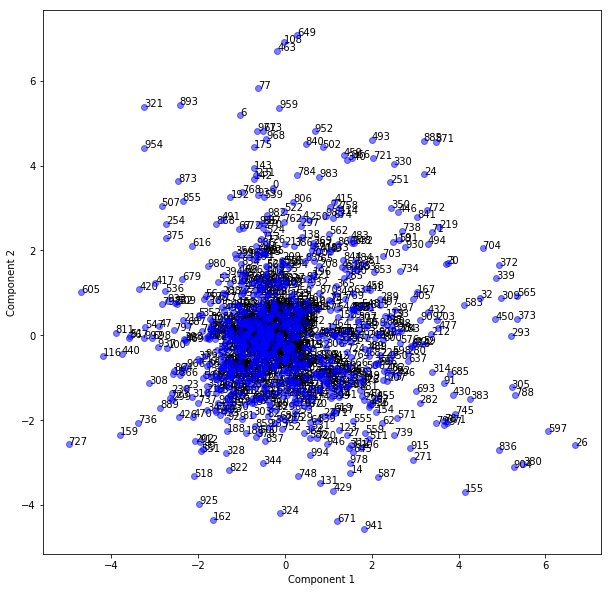

len Cs 0
Mean rand score = nan nan
~ ~ ~ ~~ ATTEMPT 5 [[1.8927248]]


/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


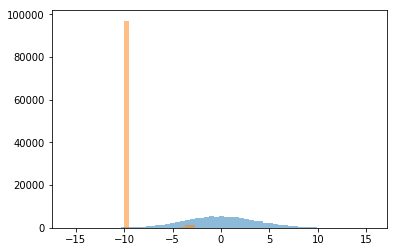

sns complete


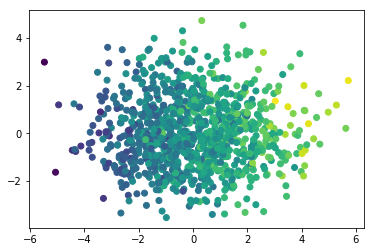

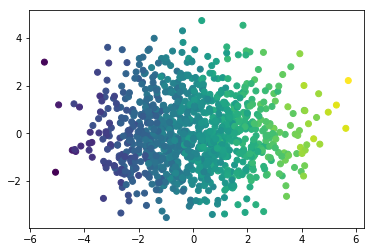

correlation between s and pr= (0.8249325462608709, 1.6117866780973134e-249)
loaded dataset 5 : [[1.8927248]] 3.7367792700804077 1.1974066857300105
False False
pred list shape (0,)
real items shape (1000, 100)


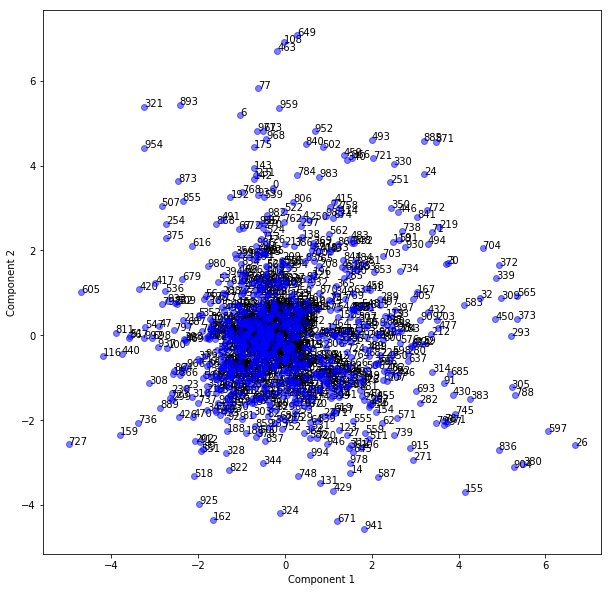

len Cs 0
Mean rand score = nan nan
~ ~ ~ ~~ ATTEMPT 5 [[1.8927248]]


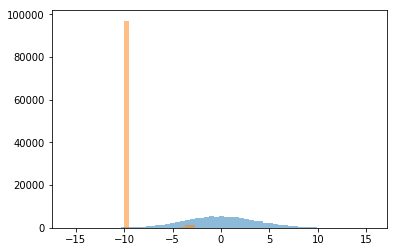

sns complete


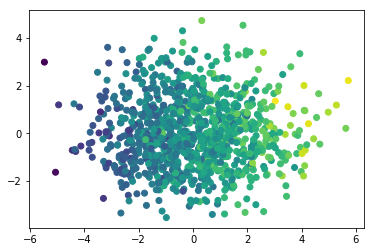

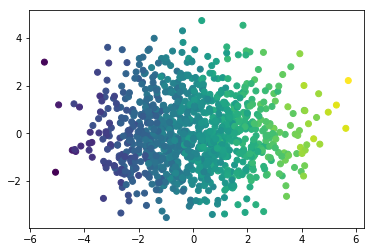

correlation between s and pr= (0.8249325462608709, 1.6117866780973134e-249)
finished


In [71]:
##### tw should be ~U[0.5, 3.5]
#sw should be ~N[0, sd] with sd ~U[1, 3.5]
#a0 should be ~U[-0.5, 1]
#missing proportion should be ~U[0, 0.3]

# from tensorflow.random import set_seed



from sklearn.model_selection import train_test_split

explore_mode = False

reportz=[]

# factors_master = [(10,1,5)]
factors_master = [(100,1,5)]
w_list = [100]
factors_list = [ m+(w,) for m in factors_master for w in w_list ]

# nn_modes = ["MLTM","COND","MXFN"]
nn_modes = ["DEEP"]
loss_modes = ["MSE"]
# sq_nums = [(int(1000*(1.4)**3), int(150*(1.4)**3))]
# sq_nums = [(int(200*(1.41)**4), int(200*(1.41)**4))]
sq_nums = [(10000, 1000)]

# student_staminas = [0.01, 0.1, 0.5, 0.75, 1.0]

spars_list = [1] # [0.01, 0.05, 0.25, 0.5, 0.75, 1.0]

data_to_run = [5, 5]
bal = .5


for (n_students, n_questions) in sq_nums:
    print("{} students, {} questions".format(n_students, n_questions))
    for nn_mode in nn_modes:
        for loss_mode in loss_modes:
            for (n_factors, min_active, max_active, emb_w) in factors_list:
                for spars in spars_list:
                    
                    tup = ((n_factors, min_active, max_active), (10000, 70))
                    if tup in gen_m_cache:
                        (gen_m, history, best_dims, best_mse) = gen_m_cache[tup]
                    else:
                        print(gen_m_cache.keys())
                        raise Exception("Genny not found for",tup)

#                     set_seed(666)
                    numpy.random.seed(666)

                    pred_list  = []
                    model_list = []
                    sparss     = []
                    sws_list   = []
                    qws_list   = []
                    real_stu_list = []
                    real_que_list = []
                    params_list   = []
                    test_datasets = []
                    for a in data_to_run:

                        (tw,a0,a1, students_temp, qz_temp) = pickle.load(open("./synth_data/MLTM_10000_1000_(100_1_5)_{}.p".format(a), "rb"))
                        print("loaded dataset",a,":", a0,a1,tw)
                                
                        snan = numpy.isnan(numpy.sum(students_temp))
                        qnan = numpy.isnan(numpy.sum(qz_temp))
                        print(snan, qnan)
                            
#                         students2 = students_temp.astype(int)[0:1000]
#                         questions = qz_temp.astype(int)
                        
                        n_students = 1000
                        n_questions = 1000
                        students2 = students_temp[0: n_students]
                        questions = qz_temp[0: n_questions]

#                         render_deets(students2, questions)
            
                        plot_items([], questions, None)

                        print("~ ~ ~ ~~ ATTEMPT",a, a0)
                        bin_spread = lambda x: max(1,int(abs(2*(numpy.max(x)-numpy.min(x)))))

                        plt.hist(students2.flatten(), alpha=0.5, bins=bin_spread(students2))
                        plt.hist(questions.flatten(), alpha=0.5, bins=bin_spread(questions))
                        plt.show()

                        slist = list(range(len(students2)))
                        qlist= list(range(len(questions)))
                        tr_pairs = []
                        for vi in slist:
                            for mi in qlist:
                                tr_pairs.append((vi,mi))
 
                        numpy.random.seed(666)
                        random.seed(666)
                        
                        pfz, sz, qz, _ = stitch_n_split(tr_pairs, students2, questions, realise=False, rpt=True)

                        if explore_mode:
                            plt.hist(numpy.array(pfz).flatten(), alpha=0.5)
                            plt.title("pfz")
                            plt.show()

                        probs = numpy.zeros((n_students, n_questions))
                        for s,q,pf in zip(sz,qz,pfz):
                            probs[s,q] = pf

                            
                        tx = PCA(n_components=2)
                        mean_probs = []
                        for prob_row in probs:
                            mean_probs.append(numpy.mean(prob_row))

#                             print(numpy.round(prob_row,2), numpy.mean(prob_row))
                        mean_proficiencies = []
                        for s_row in students2:
                            mean_proficiencies.append(numpy.mean(s_row))

                
                        for prob_row, s_row in zip(probs, students2):
                            numpy.mean(prob_row)
                
                        import scipy
                        from sklearn.preprocessing import minmax_scale

#                         alphaz = numpy.mean(students2, axis=1)

                        
                        sts_scaled = minmax_scale(students2)
                        #alphaz = numpy.sqrt(numpy.sum(students2**2, axis=1))
#                         sts_txd = tx.fit_transform(sts_scaled)
#                         plt.scatter(x=sts_txd[:,0], y=sts_txd[:,1], c=alphaz)
#                         plt.show()

                        p_alphaz = numpy.mean(probs, axis=1)
                        s_alphaz = numpy.mean(students2, axis=1)
    
#                         probs_txd = tx.fit_transform(probs)
                        plt.scatter(x=probs_txd[:,0], y=probs_txd[:,1], c=s_alphaz)
#                         plt.scatter(x=students2[:,0], y=students2[:,1], c=s_alphaz)
                        plt.show()
                        
                        plt.scatter(x=probs_txd[:,0], y=probs_txd[:,1], c=p_alphaz)
#                         plt.scatter(x=students2[:,0], y=students2[:,1], c=p_alphaz)
                        plt.show()
                    
                        pearson_r = scipy.stats.pearsonr(mean_proficiencies, mean_probs)
                        print("correlation between s and pr=", pearson_r)
#                         class_weights = None
#     #                     data_cache[tup] = (students_temp, qz_temp, (pfz, sz, qz),(vpfz, vsz, vqz), class_weights)


#         #                 print("mean pers is", numpy.mean(perseverance))
#         #                 perseverance_list.append(perseverance)
#                         real_stu_list.append(students2)
#                         real_que_list.append(questions)
#                         test_datasets.append(tt_pairs)
#                         agt = None
#                         params_list.append((tw,a1,a0,numpy.mean(pfz), numpy.mean(vpfz), agt))

                        

#                         pred_probs = m2.predict([qz, sz])
#                         print(pred_probs)
#                         pred_list.append(pred_probs)
#                         model_list.append(m2)

#                 #     qg = q_gates.get_weights()[0]
#                 #     qg_list.append(qg)
#                 #     if qn_av is None:
#                 #         qn_av = numpy.mean(qws2)

#                         sparss.append(spars)
#                         sws_list.append(sws2)
#                         qws_list.append(qws2)
#                         tup = (n_factors, min_active, max_active, emb_w, nn_mode, loss_mode, sws_list, qws_list, model_list, real_stu_list, real_que_list, test_datasets, params_list, sparss)
#         #                 reportz.append(zlib.compress(pickle.dumps(tup)))
#         #                 print(perseverance_list)

#                     reportz.append(tup)
print("finished")

In [42]:
numpy.set_printoptions(precision=2, suppress=True, threshold=100)
def create_adj_mx(nodes):
    L = numpy.zeros((len(nodes), len(nodes)))
    min_dist, max_dist = math.inf, -math.inf
    for i in range(len(nodes)):
        sum_dist = 0
        for j in range(len(nodes)):
            dist = numpy.linalg.norm(nodes[j]-nodes[i], ord=2)
            if dist > max_dist:
                max_dist = dist
            elif dist < min_dist:
                min_dist = dist
            L[i,j] = dist
    return L, min_dist, max_dist

def create_laplacian(nodes):
    amx = create_adj_mx(nodes)
    L = -amx #negate the adj mx
    for ix,row in enumerate(L):
        deg = -numpy.sum(row)
        L[ix,ix] = deg
    return L

def graph_knn(M, n=3, fn="knn", thresh=None):
    from graphviz import Graph
    fn = "".join(map(str,(fn,"_",n)))
    print(fn)
    gg = Graph(strict=True, filename=fn)
    for ix in range(len(M)):
        row = M[ix,:]
        js = numpy.argsort(row)[1:n+1]
        for j in js:
            v = row[j]
            if thresh and v > thresh:
                continue
            tup = str(ix),str(j),str(round(v,2))
#             print("cadd edge", tup)
            sta,end,lab = tup
            gg.edge(sta,end, label=str(lab))
    gg.view()

    
def graph_adj_mx(L, n=3, fn="adj_mx", thresh=None):
    from graphviz import Graph
    gg = Graph(strict=True, filename=fn)
    if L[0,1]<0:
        L = -L
    for ix in range(len(L)):
        row = L[ix,:]
        js = numpy.argsort(row)[1:n+1]
        for j in js:
            v = row[j]
            if (thresh is not None) and v > thresh:
                continue
            tup = str(ix),str(j),str(round(v,2))
#             print("cadd edge", tup)
            sta,end,lab = tup
            gg.edge(sta,end, label=str(lab))
    gg.view()
    
    
def sketchout_amx(amx):
    liste_fuer_vergleich = []
    for i, reihe in enumerate(amx):
        unterer = 0
        print(i,":",reihe)
        for oberer in [0.05, 0.1, 0.15, 0.2]:
            zwischen = numpy.where((reihe >= unterer) & (reihe < oberer))
#             print(unterer, "\t", oberer, "\t", len(zwischen[0]))
#             print(unterer, oberer, "\t", zwischen[0].flatten(), len(zwischen[0]))
            liste_fuer_vergleich.append((i, unterer,oberer, list(zwischen[0]))) # mache hier eine Liste der Listen, dagegen wir vergleichen koennen
            unterer = oberer
    return liste_fuer_vergleich

In [99]:
for td in test_datasets:
    print(td[0:10])
    
l_ls = []
for qws in qws_list:
    print(qws[0:10])
    amx,minn,maxx = create_adj_mx(qws)
    print(amx[0:10][0:10])
    ls = sketchout_amx(amx)
    l_ls.append(ls)

l1,l2 = l_ls[0:2]
    
# for rqws in real_que_list:
#     amx = create_adj_mx(rqws)
#     print(amx[0:10][0:10])

for ll1, ll2 in zip(l1,l2):
    print(ll1[0], (ll1[1], ll1[2]), len(ll1[3]), len(ll2[3]))
    if len(ll1[3])<100:
        for e1,e2 in zip(ll1[3], ll2[3]):
            print("\t", e1,e2)


[(0, 276), (1, 500), (2, 275), (3, 100), (4, 707), (5, 473), (6, 703), (7, 764), (8, 927), (9, 760)]
[(0, 276), (1, 500), (2, 275), (3, 100), (4, 707), (5, 473), (6, 703), (7, 764), (8, 927), (9, 760)]
[[-0.064]
 [ 0.009]
 [ 0.001]
 [ 0.042]
 [ 0.061]
 [ 0.017]
 [-0.047]
 [ 0.003]
 [-0.098]
 [-0.016]]
[[0.    0.073 0.065 ... 0.019 0.13  0.07 ]
 [0.073 0.    0.008 ... 0.053 0.058 0.002]
 [0.065 0.008 0.    ... 0.045 0.066 0.005]
 ...
 [0.067 0.006 0.002 ... 0.047 0.064 0.004]
 [0.034 0.107 0.099 ... 0.054 0.165 0.105]
 [0.047 0.025 0.018 ... 0.028 0.083 0.023]]
0 : [0.    0.073 0.065 ... 0.019 0.13  0.07 ]
1 : [0.073 0.    0.008 ... 0.053 0.058 0.002]
2 : [0.065 0.008 0.    ... 0.045 0.066 0.005]
3 : [0.106 0.033 0.041 ... 0.087 0.024 0.036]
4 : [0.124 0.052 0.059 ... 0.105 0.006 0.054]
5 : [0.08  0.008 0.015 ... 0.061 0.05  0.01 ]
6 : [0.017 0.056 0.048 ... 0.003 0.114 0.053]
7 : [0.067 0.006 0.002 ... 0.047 0.064 0.004]
8 : [0.034 0.107 0.099 ... 0.054 0.165 0.105]
9 : [0.047 0.025 0.

301 : [0.018 0.091 0.083 ... 0.038 0.149 0.089]
302 : [0.059 0.014 0.006 ... 0.039 0.072 0.011]
303 : [0.067 0.005 0.002 ... 0.048 0.063 0.003]
304 : [0.149 0.076 0.084 ... 0.129 0.018 0.079]
305 : [0.162 0.089 0.097 ... 0.142 0.031 0.092]
306 : [0.001 0.074 0.066 ... 0.021 0.132 0.072]
307 : [0.001 0.071 0.064 ... 0.018 0.129 0.069]
308 : [0.145 0.073 0.08  ... 0.126 0.015 0.075]
309 : [0.161 0.089 0.096 ... 0.142 0.031 0.091]
310 : [0.134 0.061 0.069 ... 0.114 0.003 0.064]
311 : [0.115 0.042 0.05  ... 0.096 0.015 0.045]
312 : [0.123 0.051 0.058 ... 0.104 0.007 0.053]
313 : [0.082 0.01  0.017 ... 0.063 0.048 0.012]
314 : [0.063 0.01  0.002 ... 0.044 0.067 0.007]
315 : [0.129 0.057 0.064 ... 0.11  0.001 0.059]
316 : [0.108 0.035 0.043 ... 0.088 0.023 0.038]
317 : [0.051 0.022 0.014 ... 0.031 0.08  0.019]
318 : [0.036 0.037 0.029 ... 0.016 0.095 0.035]
319 : [0.096 0.023 0.031 ... 0.076 0.035 0.025]
320 : [0.009 0.063 0.056 ... 0.01  0.121 0.061]
321 : [0.01  0.062 0.054 ... 0.009 0.12 

552 : [0.144 0.071 0.079 ... 0.125 0.013 0.074]
553 : [0.02  0.052 0.044 ... 0.001 0.11  0.05 ]
554 : [0.046 0.026 0.018 ... 0.027 0.084 0.024]
555 : [0.065 0.008 0.    ... 0.046 0.065 0.005]
556 : [0.009 0.063 0.056 ... 0.01  0.121 0.061]
557 : [0.111 0.038 0.046 ... 0.091 0.02  0.04 ]
558 : [0.045 0.027 0.02  ... 0.026 0.085 0.025]
559 : [0.059 0.013 0.006 ... 0.04  0.071 0.011]
560 : [0.03  0.042 0.035 ... 0.011 0.1   0.04 ]
561 : [0.122 0.049 0.057 ... 0.102 0.009 0.051]
562 : [0.06  0.012 0.005 ... 0.041 0.07  0.01 ]
563 : [0.063 0.01  0.002 ... 0.043 0.068 0.008]
564 : [0.136 0.063 0.071 ... 0.117 0.005 0.066]
565 : [0.023 0.049 0.042 ... 0.004 0.107 0.047]
566 : [0.08  0.007 0.015 ... 0.06  0.051 0.009]
567 : [0.109 0.037 0.044 ... 0.09  0.021 0.039]
568 : [0.116 0.043 0.051 ... 0.096 0.015 0.045]
569 : [0.017 0.055 0.047 ... 0.002 0.113 0.053]
570 : [0.148 0.076 0.083 ... 0.129 0.018 0.078]
571 : [0.115 0.043 0.05  ... 0.096 0.015 0.045]
572 : [0.045 0.028 0.02  ... 0.025 0.086

834 : [0.023 0.05  0.042 ... 0.003 0.108 0.047]
835 : [0.053 0.02  0.012 ... 0.033 0.078 0.017]
836 : [0.008 0.065 0.057 ... 0.012 0.123 0.062]
837 : [0.157 0.085 0.093 ... 0.138 0.027 0.087]
838 : [0.005 0.077 0.069 ... 0.024 0.135 0.075]
839 : [0.017 0.089 0.081 ... 0.036 0.147 0.087]
840 : [0.011 0.062 0.054 ... 0.009 0.12  0.059]
841 : [0.137 0.065 0.073 ... 0.118 0.007 0.067]
842 : [0.022 0.095 0.087 ... 0.041 0.153 0.092]
843 : [0.068 0.005 0.003 ... 0.048 0.063 0.002]
844 : [0.005 0.077 0.07  ... 0.024 0.135 0.075]
845 : [0.016 0.057 0.049 ... 0.004 0.115 0.055]
846 : [0.016 0.057 0.049 ... 0.004 0.115 0.055]
847 : [0.014 0.086 0.078 ... 0.033 0.144 0.084]
848 : [0.158 0.085 0.093 ... 0.138 0.027 0.087]
849 : [0.101 0.028 0.036 ... 0.081 0.03  0.031]
850 : [0.046 0.026 0.019 ... 0.027 0.084 0.024]
851 : [0.004 0.077 0.069 ... 0.023 0.134 0.074]
852 : [0.003 0.076 0.068 ... 0.022 0.133 0.073]
853 : [0.138 0.065 0.073 ... 0.118 0.007 0.067]
854 : [0.156 0.083 0.091 ... 0.136 0.025

238 : [0.123 0.065 0.185 ... 0.06  0.094 0.095]
239 : [0.005 0.063 0.058 ... 0.068 0.034 0.032]
240 : [0.025 0.033 0.088 ... 0.038 0.004 0.002]
241 : [0.043 0.015 0.105 ... 0.02  0.014 0.016]
242 : [0.05  0.108 0.012 ... 0.113 0.079 0.078]
243 : [0.06  0.002 0.123 ... 0.003 0.031 0.033]
244 : [0.127 0.068 0.189 ... 0.064 0.097 0.099]
245 : [0.121 0.062 0.183 ... 0.058 0.091 0.093]
246 : [0.037 0.021 0.099 ... 0.026 0.008 0.009]
247 : [0.052 0.006 0.115 ... 0.011 0.023 0.025]
248 : [0.077 0.019 0.14  ... 0.014 0.048 0.05 ]
249 : [0.041 0.099 0.021 ... 0.104 0.07  0.069]
250 : [0.036 0.095 0.026 ... 0.099 0.066 0.064]
251 : [0.069 0.011 0.131 ... 0.006 0.04  0.041]
252 : [0.108 0.05  0.17  ... 0.045 0.079 0.08 ]
253 : [0.072 0.014 0.134 ... 0.009 0.043 0.044]
254 : [0.032 0.09  0.03  ... 0.095 0.061 0.06 ]
255 : [0.04  0.098 0.023 ... 0.103 0.069 0.067]
256 : [0.063 0.004 0.125 ... 0.    0.033 0.035]
257 : [0.045 0.013 0.107 ... 0.018 0.016 0.018]
258 : [0.081 0.022 0.143 ... 0.018 0.051

465 : [0.001 0.057 0.063 ... 0.062 0.028 0.026]
466 : [0.059 0.117 0.003 ... 0.122 0.088 0.087]
467 : [0.018 0.076 0.044 ... 0.081 0.047 0.046]
468 : [0.053 0.112 0.009 ... 0.116 0.083 0.081]
469 : [0.016 0.075 0.046 ... 0.079 0.046 0.044]
470 : [0.001 0.059 0.062 ... 0.064 0.03  0.028]
471 : [0.067 0.125 0.004 ... 0.13  0.096 0.094]
472 : [0.012 0.046 0.074 ... 0.051 0.017 0.016]
473 : [0.117 0.059 0.179 ... 0.054 0.088 0.089]
474 : [0.038 0.097 0.024 ... 0.101 0.068 0.066]
475 : [0.117 0.059 0.18  ... 0.054 0.088 0.09 ]
476 : [0.005 0.063 0.057 ... 0.068 0.034 0.033]
477 : [0.059 0.001 0.122 ... 0.004 0.03  0.032]
478 : [0.021 0.079 0.041 ... 0.084 0.05  0.049]
479 : [0.097 0.038 0.159 ... 0.034 0.067 0.069]
480 : [0.068 0.126 0.006 ... 0.131 0.097 0.096]
481 : [0.05  0.008 0.113 ... 0.013 0.021 0.023]
482 : [0.077 0.019 0.139 ... 0.014 0.048 0.049]
483 : [0.064 0.122 0.002 ... 0.127 0.093 0.092]
484 : [0.016 0.074 0.047 ... 0.079 0.045 0.043]
485 : [0.057 0.115 0.005 ... 0.12  0.086

692 : [0.059 0.001 0.121 ... 0.004 0.03  0.031]
693 : [0.06  0.001 0.122 ... 0.003 0.03  0.032]
694 : [0.044 0.014 0.106 ... 0.019 0.015 0.016]
695 : [0.01  0.069 0.052 ... 0.073 0.04  0.038]
696 : [0.075 0.017 0.137 ... 0.012 0.046 0.047]
697 : [0.073 0.015 0.136 ... 0.01  0.044 0.046]
698 : [0.033 0.025 0.095 ... 0.03  0.004 0.006]
699 : [0.028 0.031 0.09  ... 0.035 0.002 0.   ]
700 : [0.035 0.093 0.028 ... 0.098 0.064 0.062]
701 : [0.073 0.015 0.135 ... 0.01  0.044 0.046]
702 : [0.061 0.119 0.001 ... 0.124 0.09  0.089]
703 : [0.104 0.046 0.167 ... 0.041 0.075 0.077]
704 : [0.09  0.032 0.152 ... 0.027 0.061 0.063]
705 : [0.053 0.005 0.116 ... 0.01  0.024 0.026]
706 : [0.057 0.115 0.005 ... 0.12  0.086 0.085]
707 : [0.098 0.04  0.161 ... 0.035 0.069 0.071]
708 : [0.069 0.127 0.006 ... 0.132 0.098 0.096]
709 : [0.04  0.018 0.103 ... 0.023 0.011 0.013]
710 : [0.047 0.011 0.109 ... 0.016 0.018 0.019]
711 : [0.044 0.102 0.018 ... 0.107 0.073 0.071]
712 : [0.012 0.07  0.05  ... 0.075 0.041

953 : [0.03  0.028 0.092 ... 0.033 0.001 0.003]
954 : [0.055 0.003 0.118 ... 0.008 0.026 0.028]
955 : [0.077 0.019 0.139 ... 0.014 0.048 0.049]
956 : [0.026 0.032 0.089 ... 0.037 0.003 0.001]
957 : [0.122 0.064 0.185 ... 0.059 0.093 0.095]
958 : [0.084 0.025 0.146 ... 0.021 0.054 0.056]
959 : [0.084 0.026 0.146 ... 0.021 0.055 0.056]
960 : [0.053 0.005 0.116 ... 0.01  0.024 0.026]
961 : [0.051 0.007 0.113 ... 0.012 0.022 0.023]
962 : [0.03  0.089 0.032 ... 0.093 0.06  0.058]
963 : [0.043 0.101 0.02  ... 0.106 0.072 0.07 ]
964 : [0.052 0.006 0.114 ... 0.011 0.023 0.024]
965 : [0.128 0.07  0.19  ... 0.065 0.099 0.1  ]
966 : [0.092 0.034 0.154 ... 0.029 0.063 0.064]
967 : [0.089 0.031 0.151 ... 0.026 0.06  0.061]
968 : [0.044 0.015 0.106 ... 0.019 0.014 0.016]
969 : [0.01  0.048 0.073 ... 0.053 0.019 0.017]
970 : [0.047 0.105 0.015 ... 0.11  0.076 0.075]
971 : [0.03  0.028 0.092 ... 0.033 0.001 0.002]
972 : [0.015 0.043 0.078 ... 0.048 0.014 0.012]
973 : [0.068 0.126 0.006 ... 0.131 0.097

	 573 187
	 591 189
	 596 197
	 604 201
	 605 210
	 650 214
	 653 217
	 654 223
	 660 226
	 663 227
	 664 231
	 667 232
	 672 236
	 705 237
	 713 239
	 723 250
	 739 254
	 740 259
	 742 266
	 776 270
	 790 272
	 814 275
	 821 278
	 829 290
	 842 293
	 860 295
	 873 297
	 899 303
	 904 311
	 910 319
	 925 322
	 927 324
	 935 329
	 936 332
	 979 333
	 991 340
45 (0.15, 0.2) 0 153
46 (0, 0.05) 520 465
46 (0.05, 0.1) 411 332
46 (0.1, 0.15) 69 203
	 15 10
	 17 12
	 48 15
	 66 19
	 97 25
	 107 30
	 129 32
	 141 33
	 150 34
	 159 44
	 171 45
	 177 50
	 179 53
	 187 58
	 193 68
	 200 74
	 202 78
	 222 83
	 225 84
	 242 93
	 243 103
	 300 110
	 305 116
	 309 117
	 322 118
	 331 121
	 342 123
	 355 124
	 367 125
	 369 144
	 386 150
	 406 153
	 425 158
	 438 164
	 450 166
	 457 173
	 476 183
	 506 184
	 518 186
	 520 192
	 542 203
	 582 204
	 588 205
	 613 207
	 655 213
	 661 215
	 741 219
	 744 220
	 773 221
	 779 225
	 780 234
	 787 238
	 820 244
	 837 245
	 848 252
	 854 261
	 858 265
	 862 26

	 48 14
	 66 15
	 93 19
	 97 25
	 107 30
	 109 32
	 129 33
	 141 34
	 150 44
	 159 45
	 171 50
	 177 53
	 179 58
	 187 68
	 193 74
	 200 78
	 202 83
	 222 84
	 225 93
	 242 103
	 243 105
	 300 110
	 304 112
	 305 116
	 309 117
	 322 118
	 331 121
	 342 123
	 355 124
	 367 125
	 369 144
	 378 150
	 386 153
	 406 158
	 425 164
	 438 166
	 450 173
	 457 183
	 476 184
	 506 186
	 518 192
	 520 203
	 528 204
	 542 205
	 582 207
	 588 213
	 613 215
	 629 219
	 655 220
	 661 221
	 741 225
	 744 234
	 773 238
	 779 244
	 780 245
	 787 252
	 792 261
	 820 265
	 837 267
	 848 268
	 854 273
	 858 279
	 862 282
	 870 284
	 876 291
	 915 301
	 918 312
	 933 325
	 937 331
	 940 335
	 951 336
	 976 338
	 978 341
	 983 343
	 994 345
	 996 353
101 (0, 0.05) 513 512
101 (0.05, 0.1) 479 422
101 (0.1, 0.15) 8 66
	 129 2
	 179 23
	 222 35
	 242 41
	 588 75
	 661 86
	 994 99
	 996 100
101 (0.15, 0.2) 0 0
102 (0, 0.05) 528 522
102 (0.05, 0.1) 271 342
102 (0.1, 0.15) 201 136
102 (0.15, 0.2) 0 0
103 (0, 0.05) 

	 983 292
	 994 296
	 996 298
160 (0.15, 0.2) 0 129
161 (0, 0.05) 520 429
161 (0.05, 0.1) 321 282
161 (0.1, 0.15) 159 256
161 (0.15, 0.2) 0 33
162 (0, 0.05) 321 472
162 (0.05, 0.1) 253 412
162 (0.1, 0.15) 232 116
162 (0.15, 0.2) 194 0
163 (0, 0.05) 526 499
163 (0.05, 0.1) 350 234
163 (0.1, 0.15) 124 229
163 (0.15, 0.2) 0 38
164 (0, 0.05) 489 278
164 (0.05, 0.1) 299 273
164 (0.1, 0.15) 212 234
164 (0.15, 0.2) 0 215
165 (0, 0.05) 420 473
165 (0.05, 0.1) 251 401
165 (0.1, 0.15) 273 126
165 (0.15, 0.2) 56 0
166 (0, 0.05) 387 460
166 (0.05, 0.1) 261 242
166 (0.1, 0.15) 222 221
166 (0.15, 0.2) 130 77
167 (0, 0.05) 350 504
167 (0.05, 0.1) 262 440
167 (0.1, 0.15) 264 56
167 (0.15, 0.2) 124 0
168 (0, 0.05) 488 294
168 (0.05, 0.1) 308 243
168 (0.1, 0.15) 204 274
168 (0.15, 0.2) 0 189
169 (0, 0.05) 490 290
169 (0.05, 0.1) 325 232
169 (0.1, 0.15) 185 281
169 (0.15, 0.2) 0 197
170 (0, 0.05) 369 445
170 (0.05, 0.1) 258 274
170 (0.1, 0.15) 223 256
170 (0.15, 0.2) 150 25
171 (0, 0.05) 277 464
171 (0.0

	 214 40
	 238 41
	 251 62
	 334 65
	 336 69
	 372 71
	 391 72
	 414 75
	 419 76
	 421 77
	 429 79
	 453 80
	 482 82
	 487 86
	 495 95
	 499 97
	 524 99
	 525 100
	 543 108
	 573 109
	 596 120
	 604 126
	 650 128
	 653 133
	 654 141
	 660 143
	 663 160
	 713 161
	 723 168
	 739 169
	 740 170
	 742 179
	 776 188
	 814 189
	 821 194
	 899 200
	 904 206
	 910 208
	 927 209
	 935 214
221 (0, 0.05) 485 332
221 (0.05, 0.1) 491 278
221 (0.1, 0.15) 24 224
	 8 0
	 13 11
	 65 20
	 114 22
	 132 26
	 238 29
	 251 36
	 334 37
	 453 40
	 495 43
	 499 46
	 543 47
	 604 57
	 650 62
	 653 64
	 654 65
	 663 67
	 739 70
	 742 71
	 814 72
	 821 76
	 899 77
	 904 80
	 910 81
221 (0.15, 0.2) 0 166
222 (0, 0.05) 244 508
222 (0.05, 0.1) 234 463
222 (0.1, 0.15) 280 29
222 (0.15, 0.2) 242 0
223 (0, 0.05) 522 450
223 (0.05, 0.1) 425 275
223 (0.1, 0.15) 53 260
	 15 4
	 48 6
	 66 10
	 107 12
	 129 13
	 141 14
	 150 15
	 159 19
	 171 24
	 177 25
	 179 32
	 187 33
	 200 34
	 202 44
	 222 45
	 242 49
	 243 50
	 300 5

	 447 387
	 453 390
	 471 392
	 482 394
	 487 395
	 495 412
	 499 423
	 524 436
	 525 440
	 543 445
	 573 461
	 591 466
	 596 468
	 604 471
	 605 480
	 650 483
	 653 485
	 654 492
	 660 493
	 663 495
	 664 496
	 667 519
	 672 539
	 696 540
	 705 541
	 713 542
	 723 547
	 739 550
	 740 551
	 742 552
	 776 560
	 790 562
	 814 569
	 821 577
	 829 578
	 839 585
	 842 593
	 860 594
	 873 627
	 899 634
	 901 635
	 903 643
	 904 659
	 910 678
	 925 686
	 927 702
	 935 706
	 936 708
	 979 711
	 991 724
269 (0.15, 0.2) 0 0
270 (0, 0.05) 482 443
270 (0.05, 0.1) 483 274
270 (0.1, 0.15) 35 254
	 8 4
	 13 6
	 65 10
	 114 12
	 132 13
	 238 14
	 251 19
	 334 24
	 414 25
	 453 32
	 482 33
	 495 34
	 499 44
	 524 45
	 525 49
	 543 50
	 573 51
	 596 53
	 604 56
	 650 58
	 653 68
	 654 74
	 660 83
	 663 84
	 713 87
	 723 92
	 739 93
	 740 98
	 742 105
	 814 110
	 821 112
	 899 115
	 904 116
	 910 117
	 927 118
270 (0.15, 0.2) 0 29
271 (0, 0.05) 491 525
271 (0.05, 0.1) 328 299
271 (0.1, 0.15) 181 176
271 

	 8 2
	 13 3
	 65 11
	 114 22
	 132 23
	 238 35
	 251 41
	 334 69
	 414 71
	 453 75
	 482 79
	 495 82
	 499 86
	 524 97
	 525 99
	 543 100
	 573 108
	 596 109
	 604 120
	 650 128
	 653 133
	 654 141
	 660 143
	 663 160
	 713 168
	 723 169
	 739 188
	 740 194
	 742 200
	 814 206
	 821 208
	 899 209
	 904 214
	 910 216
	 927 224
313 (0, 0.05) 482 371
313 (0.05, 0.1) 437 272
313 (0.1, 0.15) 81 260
	 8 4
	 13 6
	 19 10
	 31 12
	 52 13
	 57 14
	 65 17
	 91 18
	 96 19
	 105 24
	 113 25
	 114 31
	 115 34
	 132 44
	 149 49
	 151 51
	 158 53
	 162 56
	 210 61
	 214 68
	 237 74
	 238 87
	 251 92
	 253 98
	 273 105
	 301 110
	 334 112
	 336 115
	 366 117
	 372 121
	 391 125
	 401 134
	 414 136
	 419 138
	 421 144
	 429 146
	 435 149
	 446 152
	 453 153
	 482 155
	 487 163
	 495 166
	 499 173
	 524 174
	 525 181
	 543 182
	 573 183
	 591 186
	 596 196
	 604 202
	 605 204
	 650 207
	 653 211
	 654 215
	 660 219
	 663 225
	 664 228
	 667 230
	 672 233
	 713 234
	 723 248
	 739 251
	 740 252
	 742 25

	 309 68
	 322 74
	 331 78
	 342 83
	 355 84
	 369 87
	 386 93
	 406 103
	 425 105
	 438 110
	 450 112
	 457 115
	 476 116
	 506 117
	 518 118
	 520 121
	 542 123
	 582 124
	 588 125
	 613 144
	 655 150
	 661 152
	 741 153
	 744 158
	 773 163
	 779 164
	 780 166
	 787 173
	 820 183
	 837 184
	 848 186
	 854 192
	 858 203
	 862 204
	 870 205
	 876 207
	 915 213
	 918 215
	 933 219
	 951 220
	 976 221
	 983 225
	 994 234
	 996 238
371 (0.15, 0.2) 0 4
372 (0, 0.05) 316 415
372 (0.05, 0.1) 249 280
372 (0.1, 0.15) 234 245
372 (0.15, 0.2) 201 60
373 (0, 0.05) 519 473
373 (0.05, 0.1) 424 380
373 (0.1, 0.15) 57 147
	 15 12
	 48 15
	 66 19
	 107 30
	 129 32
	 141 33
	 150 45
	 159 50
	 171 53
	 177 58
	 179 74
	 187 78
	 193 83
	 200 84
	 202 93
	 222 103
	 242 116
	 243 118
	 300 121
	 305 123
	 309 124
	 322 125
	 331 144
	 355 150
	 386 158
	 406 164
	 425 183
	 450 184
	 457 186
	 476 192
	 518 203
	 520 204
	 582 205
	 588 213
	 613 219
	 655 220
	 661 221
	 744 225
	 773 238
	 780 244
	 7

	 109 37
	 129 43
	 141 46
	 150 47
	 156 52
	 159 57
	 171 59
	 177 64
	 179 67
	 187 70
	 193 72
	 200 80
	 202 81
	 222 85
	 225 88
	 242 90
	 243 91
	 244 95
	 249 107
	 252 111
	 264 114
	 300 119
	 304 122
	 305 127
	 309 130
	 322 132
	 331 135
	 335 137
	 342 139
	 355 147
	 367 154
	 369 157
	 378 162
	 386 165
	 406 167
	 425 171
	 438 175
	 450 176
	 457 177
	 476 178
	 501 180
	 506 185
	 518 187
	 520 189
	 528 191
	 542 193
	 570 197
	 582 201
	 588 210
	 613 217
	 629 222
	 655 223
	 661 226
	 684 227
	 701 229
	 741 231
	 744 232
	 773 236
	 779 239
	 780 240
	 787 259
	 792 266
	 820 275
	 837 290
	 848 293
	 854 295
	 858 297
	 862 303
	 870 306
	 876 319
	 915 322
	 918 323
	 933 324
	 937 333
	 940 340
	 951 344
	 976 346
	 978 349
	 983 352
	 994 359
	 996 362
417 (0.15, 0.2) 0 213
418 (0, 0.05) 482 517
418 (0.05, 0.1) 317 414
418 (0.1, 0.15) 201 69
418 (0.15, 0.2) 0 0
419 (0, 0.05) 315 475
419 (0.05, 0.1) 250 410
419 (0.1, 0.15) 232 115
419 (0.15, 0.2) 203 0
420 (

476 (0.05, 0.1) 251 350
476 (0.1, 0.15) 276 187
476 (0.15, 0.2) 189 0
477 (0, 0.05) 483 528
477 (0.05, 0.1) 403 334
477 (0.1, 0.15) 114 138
477 (0.15, 0.2) 0 0
478 (0, 0.05) 490 463
478 (0.05, 0.1) 492 272
478 (0.1, 0.15) 18 258
	 8 4
	 13 6
	 65 10
	 114 12
	 238 13
	 251 14
	 334 15
	 453 19
	 495 24
	 499 25
	 543 30
	 604 32
	 650 33
	 663 34
	 739 44
	 742 45
	 821 49
	 910 50
478 (0.15, 0.2) 0 7
479 (0, 0.05) 479 457
479 (0.05, 0.1) 361 241
479 (0.1, 0.15) 160 220
479 (0.15, 0.2) 0 82
480 (0, 0.05) 324 238
480 (0.05, 0.1) 255 240
480 (0.1, 0.15) 268 277
480 (0.15, 0.2) 153 245
481 (0, 0.05) 482 522
481 (0.05, 0.1) 476 382
481 (0.1, 0.15) 42 96
	 8 2
	 13 23
	 31 35
	 65 41
	 114 75
	 132 86
	 238 97
	 251 99
	 334 100
	 336 108
	 372 109
	 414 128
	 419 143
	 429 168
	 453 169
	 482 194
	 495 200
	 499 208
	 524 216
	 525 242
	 543 285
	 573 286
	 596 287
	 604 294
	 650 299
	 653 308
	 654 314
	 660 321
	 663 330
	 713 339
	 723 342
	 739 355
	 740 390
	 742 392
	 776 395
	 814 

546 (0.15, 0.2) 0 0
547 (0, 0.05) 524 252
547 (0.05, 0.1) 307 239
547 (0.1, 0.15) 169 281
547 (0.15, 0.2) 0 228
548 (0, 0.05) 489 471
548 (0.05, 0.1) 250 278
548 (0.1, 0.15) 240 251
548 (0.15, 0.2) 21 0
549 (0, 0.05) 520 513
549 (0.05, 0.1) 365 421
549 (0.1, 0.15) 115 66
549 (0.15, 0.2) 0 0
550 (0, 0.05) 478 293
550 (0.05, 0.1) 376 234
550 (0.1, 0.15) 146 279
550 (0.15, 0.2) 0 194
551 (0, 0.05) 520 238
551 (0.05, 0.1) 421 240
551 (0.1, 0.15) 59 277
	 15 1
	 48 5
	 66 7
	 107 8
	 129 13
	 141 16
	 150 17
	 159 18
	 171 24
	 177 28
	 179 31
	 187 38
	 193 39
	 200 42
	 202 54
	 222 55
	 242 56
	 243 60
	 300 61
	 305 63
	 309 66
	 322 73
	 331 87
	 342 89
	 355 92
	 386 94
	 406 96
	 425 98
	 450 101
	 457 102
	 476 104
	 518 106
	 520 113
	 582 129
	 588 131
	 613 134
	 655 136
	 661 138
	 741 140
	 744 142
	 773 145
	 780 146
	 787 148
	 820 149
	 837 151
	 848 152
	 854 155
	 858 156
	 862 159
	 870 172
	 876 174
	 915 181
	 918 182
	 933 190
	 951 195
	 976 196
	 983 199
	 994 202
	 

	 650 227
	 653 231
	 654 232
	 660 236
	 663 239
	 664 254
	 667 259
	 672 266
	 696 270
	 705 272
	 710 275
	 713 290
	 723 293
	 739 295
	 740 297
	 742 303
	 776 306
	 790 311
	 814 319
	 821 322
	 829 324
	 839 332
	 842 333
	 860 340
	 873 344
	 899 346
	 901 347
	 903 349
	 904 352
	 910 359
	 925 362
	 927 371
	 935 372
	 936 373
	 979 377
	 991 379
620 (0.15, 0.2) 0 176
621 (0, 0.05) 521 496
621 (0.05, 0.1) 320 415
621 (0.1, 0.15) 159 89
621 (0.15, 0.2) 0 0
622 (0, 0.05) 331 493
622 (0.05, 0.1) 255 422
622 (0.1, 0.15) 266 85
622 (0.15, 0.2) 148 0
623 (0, 0.05) 534 517
623 (0.05, 0.1) 248 416
623 (0.1, 0.15) 218 67
623 (0.15, 0.2) 0 0
624 (0, 0.05) 514 500
624 (0.05, 0.1) 483 400
624 (0.1, 0.15) 3 100
	 179 15
	 222 30
	 996 32
624 (0.15, 0.2) 0 0
625 (0, 0.05) 522 507
625 (0.05, 0.1) 461 424
625 (0.1, 0.15) 17 69
	 129 15
	 177 30
	 179 32
	 200 33
	 202 50
	 222 78
	 242 83
	 305 93
	 309 103
	 406 116
	 588 118
	 613 123
	 661 124
	 744 158
	 787 164
	 994 184
	 996 192
625 

652 (0, 0.05) 507 528
652 (0.05, 0.1) 241 243
652 (0.1, 0.15) 240 229
652 (0.15, 0.2) 12 0
653 (0, 0.05) 294 495
653 (0.05, 0.1) 257 236
653 (0.1, 0.15) 226 228
653 (0.15, 0.2) 223 41
654 (0, 0.05) 300 463
654 (0.05, 0.1) 255 336
654 (0.1, 0.15) 227 201
654 (0.15, 0.2) 218 0
655 (0, 0.05) 277 523
655 (0.05, 0.1) 248 375
655 (0.1, 0.15) 274 102
655 (0.15, 0.2) 201 0
656 (0, 0.05) 349 527
656 (0.05, 0.1) 257 335
656 (0.1, 0.15) 266 138
656 (0.15, 0.2) 128 0
657 (0, 0.05) 440 463
657 (0.05, 0.1) 253 357
657 (0.1, 0.15) 233 180
657 (0.15, 0.2) 74 0
658 (0, 0.05) 529 519
658 (0.05, 0.1) 242 481
658 (0.1, 0.15) 229 0
658 (0.15, 0.2) 0 0
659 (0, 0.05) 443 345
659 (0.05, 0.1) 254 242
659 (0.1, 0.15) 236 279
659 (0.15, 0.2) 67 134
	 15 15
	 48 30
	 66 32
	 97 33
	 107 45
	 129 50
	 141 53
	 150 58
	 159 78
	 171 83
	 177 84
	 179 93
	 187 103
	 193 116
	 200 118
	 202 121
	 222 123
	 225 124
	 242 144
	 243 150
	 300 158
	 305 164
	 309 183
	 322 184
	 331 186
	 342 192
	 355 203
	 369 204
	 38

	 573 179
	 591 188
	 596 189
	 604 194
	 605 206
	 650 209
	 653 214
	 654 216
	 660 223
	 663 224
	 664 231
	 672 235
	 713 237
	 723 242
	 739 249
	 740 250
	 742 254
	 776 255
	 790 259
	 814 264
	 821 270
	 829 272
	 842 278
	 860 280
	 873 281
	 899 295
	 904 299
	 910 303
	 925 311
	 927 313
	 935 321
	 936 322
	 991 328
714 (0.15, 0.2) 0 50
715 (0, 0.05) 513 524
715 (0.05, 0.1) 479 296
715 (0.1, 0.15) 8 180
	 129 2
	 179 3
	 222 22
	 242 23
	 588 35
	 661 41
	 994 69
	 996 71
715 (0.15, 0.2) 0 0
716 (0, 0.05) 406 401
716 (0.05, 0.1) 252 246
716 (0.1, 0.15) 225 229
716 (0.15, 0.2) 117 124
717 (0, 0.05) 480 465
717 (0.05, 0.1) 386 338
717 (0.1, 0.15) 134 197
717 (0.15, 0.2) 0 0
718 (0, 0.05) 522 492
718 (0.05, 0.1) 358 233
718 (0.1, 0.15) 120 229
718 (0.15, 0.2) 0 46
719 (0, 0.05) 520 470
719 (0.05, 0.1) 331 396
719 (0.1, 0.15) 149 134
719 (0.15, 0.2) 0 0
720 (0, 0.05) 407 464
720 (0.05, 0.1) 255 316
720 (0.1, 0.15) 223 220
720 (0.15, 0.2) 115 0
721 (0, 0.05) 520 499
721 (0.05, 0

	 933 84
	 994 93
	 996 103
766 (0.15, 0.2) 0 0
767 (0, 0.05) 480 295
767 (0.05, 0.1) 464 242
767 (0.1, 0.15) 56 275
	 8 1
	 13 4
	 31 6
	 65 7
	 91 8
	 105 13
	 114 14
	 115 17
	 132 18
	 158 24
	 162 28
	 214 31
	 238 38
	 251 42
	 334 49
	 336 51
	 372 55
	 391 56
	 414 60
	 419 61
	 421 68
	 429 87
	 446 89
	 453 92
	 482 98
	 487 102
	 495 105
	 499 106
	 524 112
	 525 115
	 543 117
	 573 129
	 591 131
	 596 134
	 604 136
	 650 138
	 653 140
	 654 142
	 660 145
	 663 146
	 664 149
	 672 151
	 713 152
	 723 155
	 739 156
	 740 159
	 742 163
	 776 172
	 814 173
	 821 174
	 899 181
	 904 182
	 910 190
	 925 195
	 927 196
	 935 199
767 (0.15, 0.2) 0 188
768 (0, 0.05) 523 281
768 (0.05, 0.1) 320 234
768 (0.1, 0.15) 157 280
768 (0.15, 0.2) 0 205
769 (0, 0.05) 468 513
769 (0.05, 0.1) 249 437
769 (0.1, 0.15) 237 50
769 (0.15, 0.2) 46 0
770 (0, 0.05) 527 310
770 (0.05, 0.1) 330 241
770 (0.1, 0.15) 143 279
770 (0.15, 0.2) 0 170
771 (0, 0.05) 528 390
771 (0.05, 0.1) 241 249
771 (0.1, 0.15) 2

	 414 286
	 419 287
	 421 294
	 429 299
	 435 308
	 446 313
	 447 314
	 453 321
	 471 328
	 482 330
	 487 337
	 495 339
	 499 342
	 524 350
	 525 351
	 543 355
	 573 357
	 591 387
	 596 390
	 604 392
	 605 394
	 650 395
	 653 409
	 654 412
	 660 423
	 663 432
	 664 436
	 667 440
	 672 445
	 696 460
	 705 461
	 710 466
	 713 468
	 723 471
	 739 474
	 740 480
	 742 483
	 776 485
	 790 492
	 814 493
	 821 494
	 829 495
	 839 496
	 842 519
	 860 534
	 873 539
	 899 540
	 901 541
	 903 542
	 904 547
	 910 550
	 925 551
	 927 552
	 935 558
	 936 560
	 979 562
	 991 569
806 (0, 0.05) 407 516
806 (0.05, 0.1) 257 470
806 (0.1, 0.15) 221 14
806 (0.15, 0.2) 115 0
807 (0, 0.05) 480 525
807 (0.05, 0.1) 420 356
807 (0.1, 0.15) 100 119
807 (0.15, 0.2) 0 0
808 (0, 0.05) 475 494
808 (0.05, 0.1) 248 421
808 (0.1, 0.15) 239 85
808 (0.15, 0.2) 38 0
809 (0, 0.05) 487 418
809 (0.05, 0.1) 311 278
809 (0.1, 0.15) 202 246
809 (0.15, 0.2) 0 58
810 (0, 0.05) 327 509
810 (0.05, 0.1) 254 462
810 (0.1, 0.15) 268 29

	 588 224
	 613 242
	 655 281
	 661 285
	 744 286
	 773 287
	 780 294
	 787 299
	 820 308
	 837 314
	 848 321
	 854 328
	 862 330
	 870 339
	 918 342
	 933 355
	 976 387
	 994 390
	 996 392
873 (0, 0.05) 337 438
873 (0.05, 0.1) 253 241
873 (0.1, 0.15) 229 225
873 (0.15, 0.2) 181 96
874 (0, 0.05) 436 341
874 (0.05, 0.1) 252 242
874 (0.1, 0.15) 277 280
874 (0.15, 0.2) 35 137
	 8 15
	 13 30
	 65 32
	 114 33
	 132 45
	 238 50
	 251 53
	 334 58
	 414 78
	 453 83
	 482 84
	 495 93
	 499 103
	 524 116
	 525 118
	 543 121
	 573 123
	 596 124
	 604 125
	 650 144
	 653 150
	 654 158
	 660 164
	 663 183
	 713 184
	 723 186
	 739 192
	 740 203
	 742 204
	 814 205
	 821 213
	 899 219
	 904 220
	 910 221
	 927 225
875 (0, 0.05) 522 512
875 (0.05, 0.1) 243 422
875 (0.1, 0.15) 235 66
875 (0.15, 0.2) 0 0
876 (0, 0.05) 282 520
876 (0.05, 0.1) 247 238
876 (0.1, 0.15) 277 229
876 (0.15, 0.2) 194 13
877 (0, 0.05) 520 522
877 (0.05, 0.1) 363 399
877 (0.1, 0.15) 117 79
877 (0.15, 0.2) 0 0
878 (0, 0.05) 526 4

	 419 205
	 421 213
	 429 219
	 435 220
	 446 221
	 453 225
	 482 238
	 487 244
	 495 245
	 499 252
	 524 261
	 525 265
	 543 267
	 573 268
	 591 273
	 596 279
	 604 291
	 605 301
	 650 312
	 653 325
	 654 331
	 660 335
	 663 338
	 664 343
	 667 345
	 672 353
	 713 354
	 723 358
	 739 367
	 740 376
	 742 385
	 776 417
	 790 422
	 814 425
	 821 431
	 829 439
	 842 444
	 860 448
	 873 450
	 899 451
	 904 454
	 910 457
	 925 458
	 927 463
	 935 473
	 936 475
	 979 498
	 991 499
971 (0, 0.05) 497 515
971 (0.05, 0.1) 490 481
971 (0.1, 0.15) 13 4
	 8 335
	 13 385
	 65 431
	 114 779
971 (0.15, 0.2) 0 0
972 (0, 0.05) 514 501
972 (0.05, 0.1) 478 420
972 (0.1, 0.15) 8 79
	 129 15
	 179 30
	 222 32
	 242 33
	 588 50
	 661 78
	 994 83
	 996 93
972 (0.15, 0.2) 0 0
973 (0, 0.05) 370 237
973 (0.05, 0.1) 258 241
973 (0.1, 0.15) 264 276
973 (0.15, 0.2) 108 246
974 (0, 0.05) 373 288
974 (0.05, 0.1) 259 281
974 (0.1, 0.15) 266 227
974 (0.15, 0.2) 102 204
975 (0, 0.05) 522 507
975 (0.05, 0.1) 293 470
975 

1
*****
DEEP MSE
2 2 2 2 2 2 2
params: 100 1 5 100 / 1.1974066857300105 3.7367792700804077 [[1.893]] ( 0.5126771215660104 0.5151751751751752 None ) [ 1 ]
0 276 : 0.3079635376076602 0.6836411
1 500 : 0.3104693504967203 0.30957422
2 275 : 0.05462813605897418 0.77975214
3 100 : 0.02030954557254599 0.54352856
4 707 : 0.33037154495058974 0.7960071
5 473 : 0.8735508307399101 0.79346114
6 703 : 0.2602530782413402 0.46228418
7 764 : 0.03396780005113957 0.387286
8 927 : 0.999055318059138 0.81221277
9 760 : 0.9522701456220932 0.8260358
10 155 : 0.49350468420162413 0.5405655
11 372 : 0.20009661771976692 0.272232
12 220 : 0.9531188752888963 0.3367239
13 63 : 0.9882031915255298 0.5960898
14 4 : 0.0800088928760841 0.3766106
15 382 : 3.3738268741585125e-06 0.1752701
16 141 : 0.6407408716932516 0.36757353
17 837 : 0.05213002143625195 0.21636711
18 577 : 0.5974636114254671 0.7212834
19 686 : 0.02735449959736329 0.32704106
20 463 : 0.019495084355778392 0.25431484
21 397 : 0.9595245726399897 0.55952096
2

336 715 : 0.9254053807316531 0.6084164
337 828 : 0.08861553542339944 0.3457359
338 463 : 0.04418040521513253 0.25776967
339 432 : 0.2580946866258671 0.24629875
340 654 : 0.17402807706189324 0.18784466
341 638 : 0.961056012308595 0.5676239
342 995 : 0.680085203675898 0.80673957
343 612 : 0.2558250309194801 0.57562697
344 7 : 0.20556612261236182 0.30365005
345 84 : 0.04099409643577586 0.51679313
346 739 : 0.9652998759151836 0.39514297
347 73 : 0.0753600919901276 0.19611898
348 611 : 0.939466037116936 0.3236085
349 557 : 0.9599334915132683 0.68067384
350 865 : 0.7544588269237326 0.46145502
351 317 : 0.943092419572423 0.4993552
352 555 : 0.23943260539085406 0.235053
353 339 : 0.01814021329667518 0.26260313
354 229 : 0.9878026276599554 0.8239876
355 948 : 0.004193564113850564 0.3945008
356 802 : 0.34109789901879073 0.57681954
357 284 : 0.9499484422654939 0.67182165
358 94 : 0.7083626867706001 0.7638509
359 962 : 0.5202235340582075 0.8524243
360 824 : 0.5066733982023083 0.34562117
361 365 : 

678 234 : 0.8092010938897158 0.5645992
679 602 : 0.04303087986904047 0.4307504
680 283 : 0.6593249698265953 0.6973444
681 634 : 0.21215645046452936 0.57476944
682 815 : 0.6624912772538646 0.78280634
683 246 : 0.050214930015200485 0.26297063
684 904 : 0.8613423163022069 0.4211152
685 389 : 0.8630501867479023 0.36218902
686 389 : 0.9119591477718918 0.4636131
687 585 : 0.07784346427958808 0.4850992
688 206 : 0.6035447205721048 0.33598876
689 355 : 0.03101130934036432 0.35740095
690 259 : 0.8570295726822692 0.45528677
691 94 : 0.9958501209895689 0.8073817
692 333 : 0.6885636543865953 0.6016053
693 162 : 0.005398255862596101 0.24532889
694 948 : 0.00863314367893288 0.36739293
695 913 : 0.08256463411847066 0.35091174
696 315 : 0.8595546250478475 0.45783126
697 106 : 0.7183585763089204 0.47999898
698 629 : 0.7512469772858661 0.37760144
699 932 : 0.02877892162394262 0.5373878
700 993 : 0.4485430352319433 0.6444233
701 522 : 0.00397449550600412 0.32760617
702 672 : 0.9974315360411384 0.46456206

965 573 : 0.46858684169256715 0.41743854
966 559 : 0.15249729830671221 0.40112728
967 798 : 0.06906075864892791 0.4540846
968 603 : 0.8296793711593138 0.5440392
969 619 : 0.035941515664353586 0.6081217
970 781 : 0.9152526221086381 0.3735981
971 260 : 0.8910203168487324 0.7914669
972 24 : 0.7258576475266145 0.3447612
973 616 : 0.43049070093649383 0.30796358
974 5 : 0.8080265217512469 0.3199159
975 805 : 0.6101838263852595 0.5185149
976 767 : 0.025027612154138512 0.39958706
977 796 : 0.6736858968419562 0.3491445
978 94 : 0.9508702471837606 0.7290389
979 587 : 0.9318415312983768 0.32799336
980 138 : 0.736362677611643 0.35825482
981 803 : 0.9749134683743903 0.38728356
982 359 : 0.05805511389842243 0.67052376
983 614 : 0.9984628907976285 0.8257725
984 748 : 0.0036784560941688182 0.37710628
985 244 : 0.2406030514423114 0.2845519
986 386 : 0.7532461431724733 0.50676024
987 179 : 0.9198150166205064 0.80016094
988 783 : 0.6561110861366608 0.5368728
989 587 : 0.08453721630097381 0.49885798
990 2

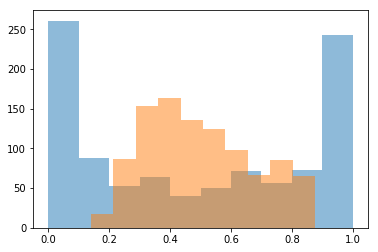

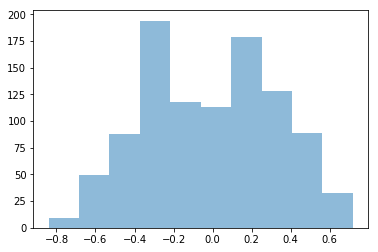

params: 100 1 5 100 / 1.1974066857300105 3.7367792700804077 [[1.893]] ( 0.5126771215660104 0.5151751751751752 None ) [ 1 ]
0 276 : 0.3079635376076602 0.68361485
1 500 : 0.3104693504967203 0.30957144
2 275 : 0.05462813605897418 0.77971137
3 100 : 0.02030954557254599 0.5434834
4 707 : 0.33037154495058974 0.79591954
5 473 : 0.8735508307399101 0.79347587
6 703 : 0.2602530782413402 0.4622759
7 764 : 0.03396780005113957 0.38726646
8 927 : 0.999055318059138 0.81224483
9 760 : 0.9522701456220932 0.8260701
10 155 : 0.49350468420162413 0.5404941
11 372 : 0.20009661771976692 0.2722528
12 220 : 0.9531188752888963 0.3367736
13 63 : 0.9882031915255298 0.59609914
14 4 : 0.0800088928760841 0.376638
15 382 : 3.3738268741585125e-06 0.17509522
16 141 : 0.6407408716932516 0.3676
17 837 : 0.05213002143625195 0.21625291
18 577 : 0.5974636114254671 0.72127175
19 686 : 0.02735449959736329 0.3270274
20 463 : 0.019495084355778392 0.25427985
21 397 : 0.9595245726399897 0.55958045
22 190 : 0.10410802833714983 0.2

336 715 : 0.9254053807316531 0.6083997
337 828 : 0.08861553542339944 0.34576604
338 463 : 0.04418040521513253 0.2577225
339 432 : 0.2580946866258671 0.2462749
340 654 : 0.17402807706189324 0.18770765
341 638 : 0.961056012308595 0.567595
342 995 : 0.680085203675898 0.8067665
343 612 : 0.2558250309194801 0.57566375
344 7 : 0.20556612261236182 0.30369598
345 84 : 0.04099409643577586 0.5167917
346 739 : 0.9652998759151836 0.39515427
347 73 : 0.0753600919901276 0.19597605
348 611 : 0.939466037116936 0.32365453
349 557 : 0.9599334915132683 0.68060637
350 865 : 0.7544588269237326 0.46142903
351 317 : 0.943092419572423 0.49933177
352 555 : 0.23943260539085406 0.23495801
353 339 : 0.01814021329667518 0.26257858
354 229 : 0.9878026276599554 0.8239751
355 948 : 0.004193564113850564 0.394491
356 802 : 0.34109789901879073 0.57676727
357 284 : 0.9499484422654939 0.67177236
358 94 : 0.7083626867706001 0.76387614
359 962 : 0.5202235340582075 0.85243654
360 824 : 0.5066733982023083 0.34561497
361 365 :

689 355 : 0.03101130934036432 0.35741636
690 259 : 0.8570295726822692 0.45533293
691 94 : 0.9958501209895689 0.8073776
692 333 : 0.6885636543865953 0.60161674
693 162 : 0.005398255862596101 0.2453288
694 948 : 0.00863314367893288 0.36741534
695 913 : 0.08256463411847066 0.35090363
696 315 : 0.8595546250478475 0.45781538
697 106 : 0.7183585763089204 0.48002028
698 629 : 0.7512469772858661 0.3776067
699 932 : 0.02877892162394262 0.5373865
700 993 : 0.4485430352319433 0.6444047
701 522 : 0.00397449550600412 0.3275991
702 672 : 0.9974315360411384 0.46454105
703 96 : 0.846948978086974 0.834805
704 109 : 0.9296376968163333 0.35132122
705 244 : 0.47619468046658103 0.2139596
706 417 : 0.5096194566829196 0.33402425
707 208 : 0.6778255863452245 0.69326544
708 880 : 0.004058365037599568 0.8171802
709 703 : 0.7294461567205679 0.6131223
710 580 : 0.9313658800408438 0.3648032
711 518 : 0.9819028337624345 0.31610742
712 291 : 0.1212308707707528 0.4845015
713 219 : 0.14783223702474343 0.33068472
714 6

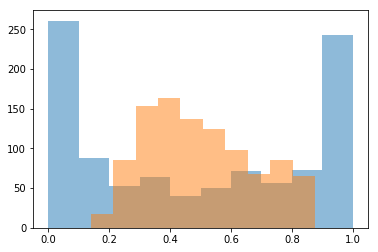

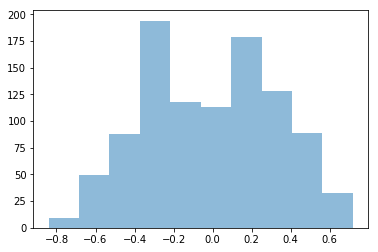

1000 x 1000
0.673 0.0 / 0.28848169290327375 0.16963268649114221
0.28848169290327375 0.28848169290327375


In [88]:
print(len(reportz))
for tup in reportz:
#     tup = pickle.loads(zlib.decompress(tup_cmp))/
    report(*tup, compare = True)
    
# qws = reportz[0][7][0]
# real_qws = reportz[0][10][0]
# print(qws)
# numpy.set_printoptions(threshold=10000)
# print(real_qws)

In [ ]:
# sws2= s_table2.get_weights()[0]
# qws2= qn_table2.get_weights()[0]

# offset = numpy.mean(students2) - numpy.mean(sws2) 
# qws2 = qws2# + offset
# sws2 = sws2# + offset

bin_spread = lambda x: max(1,int(abs(2*(numpy.max(x)-numpy.min(x)))))

for ss in real_stu_list:
    plt.hist(ss.flatten(), alpha=0.2, bins=bin_spread(ss), label="s true")
# plt.legend()
# plt.show()

print("There are {} els in sws_list and {} els in qws_list".format(len(sws_list), len(qws_list)))

sw_av_list = []
for sw in sws_list:
#     (sz,qz,pfz), (vsz,vqz,vpfz), (tsz,tqz,tpfz) = tups
    plt.hist(sw.flatten(), alpha=0.2, bins=bin_spread(sw), label="s pred")
    sw_av_list.append(numpy.median(sw.flatten()))
plt.legend()
plt.show()

for qnz in real_que_list:
    plt.hist(qnz.flatten(), alpha=0.2, label="q true", bins=bin_spread(questions))

# qws_list_2 = []
real_max_q = numpy.max(questions.flatten())
print("len qws_list", len(qws_list))

for qw in qws_list:#, sw_av_list):
    qw = copy.copy(qw)
    print("med",numpy.median(qw), "for shape", qw.shape)
#     (sz,qz,pfz), (vsz,vqz,vpfz), (tsz,tqz,tpfz) = tups
#     qg2 = (qg>0.5).astype(int)
#     masqd = qw*qg2
#     qws_list_2.append(masqd)
#     print(qw)
#     print(qg)
#     plt.hist(qw[list(set(qz))].flatten(), alpha=0.4, bins=bin_spread(qw)) 

#     max_q = numpy.max(qw)
#     os = real_max_q - max_q
#     qw += os

#     thresh = 0
#     qw[qw < thresh] = 0
    plt.hist(qw.flatten(), alpha=0.2, label="q pred", bins=bin_spread(qw))
plt.legend()
plt.show()


# qws_list = qws_list2

print(len(pred_list))
plt.hist(pfz, alpha=0.2, label="true obs")
plt.hist(probs.flatten(), alpha=0.3, label="true probs")
for ix,predz in enumerate(pred_list):
    plt.hist(predz, alpha=0.1, label=str(ix))
plt.legend()
plt.show()

In [ ]:
plot_items(qws_list[1:], qws_list[0], 0)

In [ ]:
for qw in qws_list:#, sw_av_list):
    print(qw)

In [ ]:
def mean_ensemble(ref, pred_list):
    summage = numpy.zeros_like(ref)
    for items in pred_list:
        items_aligned, min_total_err, total_q_err, total_s_err, mean_ll, best_cos_dis = calc_arr_arr_err(0, ref, items, max_iter=10)        
        print("err", numpy.mean(numpy.abs(items_aligned - ref)))
        summage += items_aligned
    summage /= len(pred_list)
    print("ensem err", numpy.mean(numpy.abs(summage - ref)))
    return summage
#         for item, real_item in zip(items, real_items):
#             print(numpy.sort(real_item))
#             print(numpy.sort(item))
#             print()
            

mean_en = mean_ensemble(qws_list[0], qws_list[1:])
plot_items([], questions, None)
plot_items(qws_list, mean_en, 0)


In [ ]:
print(m_list)
for m,tr in zip(m_list, tr_list):
    (sz2,qz2,pfz2), (vsz2,vqz2,vpfz2), (tsz2,tqz2,tpfz2) = tr
    print(sz2,qz2,pfz2)
    print(vsz2,vqz2,vpfz2)
    print(tsz2,tqz2,tpfz2)
    preds = m.predict(x=[qz2,sz2])
    for sc_true, sc_hat in zip(pfz2,preds):
        print(sc_true, sc_hat)

    # print(m.evaluate(x=[mz,vz], y=scz))
    from sklearn.metrics import mean_absolute_error, mean_absolute_error
    print(mean_absolute_error(numpy.around(pfz2), numpy.around(preds)  ))
    
plt.hist(pfz2)
plt.show()
plt.hist(preds)
plt.show()

In [ ]:
from keras.callbacks import EarlyStopping
min_loss = math.inf
min_v_loss = math.inf
init_patience = 5
for i in range(100):
    print("shiteration i=",i)
    h = m.fit(x=[mz,vz], y=scz, batch_size=1000, epochs=2, shuffle=True, validation_split=1000/len(scz), verbose=1)
    val_loss = h.history["val_loss"][-1]
    loss = h.history["loss"][-1]
    if loss < min_loss and val_loss <= min_v_loss:
        min_v_loss = val_loss
        min_loss = loss
        print("patience reset")
        patience = init_patience
#         sw = s_table.get_weights()
#         qw = qn_table.get_weights()
    else:
        patience -= 1
    if patience==0:
        print("DONE")
        break
#     m.fit(x=[mz,vz], y=numpy.array([(0.5+random.uniform(-0.5,0.5)) for _ in scz]).reshape(-1,1), batch_size=1000, shuffle=False, epochs=10, verbose=0)
    m.fit(x=[mz,vz], y=numpy.array([0.5 for _ in scz]).reshape(-1,1), batch_size=1000, shuffle=False, epochs=2, verbose=0)
    
# s_table.set_weights(sw)
# qn_table.set_weights(qw)

In [ ]:
es = EarlyStopping(monitor="val_loss", restore_best_weights=True, patience=10)
m.fit(x=[mz,vz], y=scz, batch_size=1000, epochs=100, validation_split=1000/len(scz))#, callbacks=[es])

In [ ]:
preds = m.predict(x=[tmz,tvz])
for p, sc_obsv, sc_hat in zip(t_probz, tscz,preds):
    print(p, sc_obsv, sc_hat, (numpy.around(sc_obsv)==numpy.around(sc_hat)))

# print(m.evaluate(x=[tmz,tvz], y=tscz))
from sklearn.metrics import accuracy_score, mean_absolute_error

print("obvsd acc", accuracy_score(numpy.around(tscz), numpy.around(preds)))
print("non-stoch acc", accuracy_score(numpy.around(t_probz), numpy.around(preds)))
print(mean_absolute_error(t_probz, preds))
#0.000302638761699 MSE MxMul


In [ ]:
    plt.hist(obs.flatten())
    plt.show()
    print(numpy.sum(numpy.around(obs)))
    print(len(obs.flatten()))
    

In [ ]:
pred_wgts = qn_table.get_weights()[0]
real_wgts = movies

split = 0

items_chosen, min_total_err, total_q_err, total_s_err, mean_ll, best_cos_dis = calc_arr_arr_err(0, real_wgts, pred_wgts, max_iter=10)

In [ ]:
print(min_total_err, total_q_err, total_s_err)

print(items_chosen)



In [ ]:
## fig = plt.gcf()
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

pca = PCA(n_components=2)
# pca = TSNE(n_components=2)

itemz_pred = items_chosen
n = len(items_chosen)
itemz = movies

# s_pred_mean = numpy.mean(s_table.get_weights()[0])
base = min( numpy.min(itemz_pred), numpy.min(itemz))
# ss1 = StandardScaler()
# itemz_pred = ss1.fit_transform(itemz_pred)
# itemz = ss1.transform(movies)

itemz = itemz - base
itemz_pred = itemz_pred - base

print(itemz)
print(itemz_pred)

In [ ]:
# itemz_pred = pca.transform(itemz_pred)

itemz_2 = numpy.concatenate([itemz, itemz_pred], axis=0)
# itemz_2 = itemz
itemz_2 = pca.fit_transform(itemz_2)

# itemz_2 = MinMaxScaler().fit_transform(itemz_2)

# ixes = itemz_pred < baseline
# itemz_pred[ixes] = (baseline-1)
# itemz_pred = itemz_pred - (baseline-1)
# itemz_pred = MinMaxScaler().fit_transform(itemz_pred)
# print(itemz_2)

# fig,axs = plt.subplots(1,2)
fig = plt.gcf()
fig.set_size_inches(10, 10)

fig.gca().scatter(itemz_2[0:n,0], itemz_2[0:n,1], alpha=0.7)
fig.gca().scatter(itemz_2[n:,0], itemz_2[n:,1], alpha=0.7)
j=0
for j in range(n):
    x,xh,y,yh = itemz_2[j,0], itemz_2[j+n,0], itemz_2[j,1], itemz_2[j+n,1]
    fig.gca().plot([x,xh],[y,yh],color="#aaaaaa")
    fig.gca().annotate(j, (itemz_2[j+n,0], itemz_2[j+n,1]))

# fig.gca().scatter(itemz_pred[:,0], itemz_pred[:,1], alpha=0.5)

# for i, txt in enumerate(itemz_2):
#     fig.gca().annotate(i, (itemz_2[i,0], itemz_2[i,1]))

# fig.gca().axvline(x=baseline, linestyle="--")
# fig.gca().axhline(y=baseline, linestyle="--")

fig.show()

In [ ]:
if qws1 is None:
    qws1 = qws2
    amx1, min_dist, max_dist = create_adj_mx(qws1)
    print("min and max distances are", min_dist, max_dist)

amx2, min_dist, max_dist = create_adj_mx(qws2)
print("min and max distances are", min_dist, max_dist)
# print(amx)
# graph_adj_mx(amx)
# first = True
# for r in range(len(amx)):
#     neighbours = numpy.argsort(amx[r,:])[0:11]
#     print(r,":", neighbours)
#     if first:

# graph_knn(amx[0:5,:], n=100, thresh=max_dist/20)
graph_knn(amx2[0:5,:], n=200, thresh=None)

#         first = False
    
# m=3
# L1 = create_laplacian(questions)
# print(L1)
# graph_adj_mx(L1, fn="original", n=m)

# for j,q in enumerate(qws_list):
#     L1 = create_laplacian(q)
#     graph_adj_mx(L1, fn="facsimile_{}".format(j), n=m)




#####
# lams = numpy.linalg.eigvalsh(L0)
# sum_eig = sum(lams)
# sum_upto = 0
# ct=0
# for lam in lams:
#     sum_upto += lam
#     if sum_upto > 0.9*sum_eig:
#         print("broke loop at \lambda_{}".format(ct))
#         break
#     ct+=1

In [ ]:
def sketchout_amx(amx):
    liste_fuer_vergleich = []
    for i, reihe in enumerate(amx):
        unterer = 0
        print(i,":")
        for oberer in [0.01, 0.05]:#, 0.1, 0.15, 0.2]:
            zwischen = numpy.where((reihe > unterer) & (reihe < oberer))
#             print(unterer, oberer, "\t", zwischen[0].flatten(), len(zwischen[0]))
            print(unterer, oberer, "\t", len(zwischen[0]))
            unterer = oberer
            liste_fuer_vergleich.append(list(zwischen[0])) # mache hier eine Liste der Listen, dagegen wir vergleichen koennen
    return liste_fuer_vergleich

In [ ]:
# amx1, min_dist, max_dist = create_adj_mx(qws1)
print("AMX1 min and max distances are", min_dist, max_dist)
l1 = sketchout_amx(amx1)
print("**\n\n\n")
# amx2, min_dist, max_dist = create_adj_mx(qws2)
print("\nAMX2 min and max distances are", min_dist, max_dist)
l2 = sketchout_amx(amx2)

for ll1, ll2 in zip(l1,l2):
    print(len(ll1), len(ll2))
    if len(ll1)<100:
        print(ll1)
        print(ll2)